In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/2nd_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




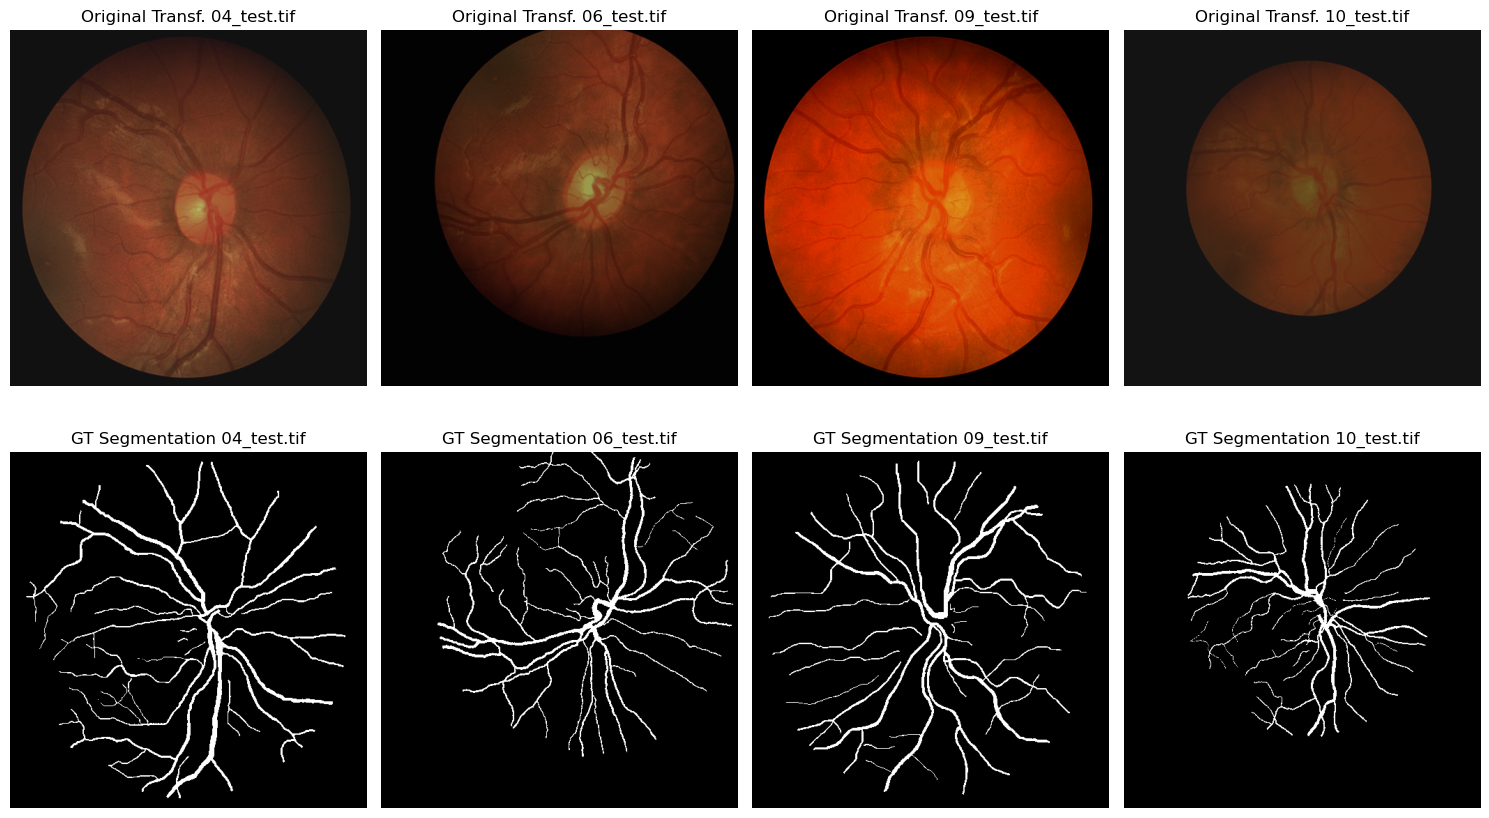

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 8

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
# from unet import UNet
# model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# from vig import ViGClassifier
# NUM_PATCHES:int = 196    #196
# PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
# print(f"{PATCH_SIZE=}")
# model = ViGClassifier(in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                    n_classes = NUM_CHANNELS_OUT,                                  # number of classes to predict
#                    num_patches = NUM_PATCHES,                                      
#                    patch_size = PATCH_SIZE,
#                    output_size = IMG_SIZE,
#                    out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                    num_ViGBlocks=12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)
#                    hidden_layer=1024,
#                    num_edges=7,                                                   # number of neigbours per node
#                    head_num=2,
#                   )


from vig_unet import ViGUNet
NUM_PATCHES:int = 14*14   #196         # ONLY PERFECT SQUARES
PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
model = ViGUNet(n_channels = NUM_CHANNELS_IN,
                n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
                in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
                out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
                num_patches = NUM_PATCHES,
                num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
                num_edges = 9,   #9                                              # number of neigbours per node
                head_num = 1,    #1
                patch_size = PATCH_SIZE,
                output_size = IMG_SIZE,
                )


# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 1000

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.25, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch: 1/1000 | Training loss: 0.15119 | Validation loss: 0.30488 | Training accuracy: 92.63% | Validation accuracy: 93.25%




100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 2/1000 | Training loss: 0.15182 | Validation loss: 0.30612 | Training accuracy: 93.28% | Validation accuracy: 93.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Epoch: 3/1000 | Training loss: 0.15237 | Validation loss: 0.30866 | Training accuracy: 93.79% | Validation accuracy: 94.34%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch: 4/1000 | Training loss: 0.15053 | Validation loss: 0.31101 | Training accuracy: 93.08% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Epoch: 5/1000 | Training loss: 0.15201 | Validation loss: 0.30550 | Training accuracy: 94.10% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch: 6/1000 | Training loss: 0.15141 | Validation loss: 0.29197 | Training accuracy: 94.00% | Validation accuracy: 90.39%




100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch: 7/1000 | Training loss: 0.15033 | Validation loss: 0.30058 | Training accuracy: 93.66% | Validation accuracy: 93.11%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch: 8/1000 | Training loss: 0.14876 | Validation loss: 0.29799 | Training accuracy: 92.87% | Validation accuracy: 93.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Epoch: 9/1000 | Training loss: 0.14904 | Validation loss: 0.29388 | Training accuracy: 93.30% | Validation accuracy: 92.35%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Epoch: 10/1000 | Training loss: 0.14998 | Validation loss: 0.30000 | Training accuracy: 94.05% | Validation accuracy: 93.00%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Epoch: 11/1000 | Training loss: 0.14817 | Validation loss: 0.29554 | Training accuracy: 93.39% | Validation accuracy: 94.14%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch: 12/1000 | Training loss: 0.14829 | Validation loss: 0.29332 | Training accuracy: 93.61% | Validation accuracy: 92.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch: 13/1000 | Training loss: 0.14755 | Validation loss: 0.30197 | Training accuracy: 93.52% | Validation accuracy: 93.47%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 14/1000 | Training loss: 0.14817 | Validation loss: 0.31465 | Training accuracy: 94.18% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 15/1000 | Training loss: 0.14605 | Validation loss: 0.30302 | Training accuracy: 93.37% | Validation accuracy: 93.07%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 16/1000 | Training loss: 0.14536 | Validation loss: 0.30011 | Training accuracy: 93.40% | Validation accuracy: 92.30%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 17/1000 | Training loss: 0.14388 | Validation loss: 0.30776 | Training accuracy: 92.93% | Validation accuracy: 95.47%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 18/1000 | Training loss: 0.14577 | Validation loss: 0.30184 | Training accuracy: 94.28% | Validation accuracy: 93.24%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Epoch: 19/1000 | Training loss: 0.14259 | Validation loss: 0.30414 | Training accuracy: 92.96% | Validation accuracy: 94.33%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 20/1000 | Training loss: 0.14319 | Validation loss: 0.29786 | Training accuracy: 93.85% | Validation accuracy: 92.80%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 21/1000 | Training loss: 0.14162 | Validation loss: 0.29626 | Training accuracy: 93.34% | Validation accuracy: 92.72%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 22/1000 | Training loss: 0.14021 | Validation loss: 0.29404 | Training accuracy: 93.03% | Validation accuracy: 93.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 23/1000 | Training loss: 0.14081 | Validation loss: 0.29087 | Training accuracy: 93.84% | Validation accuracy: 90.79%




100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 24/1000 | Training loss: 0.13943 | Validation loss: 0.29215 | Training accuracy: 93.68% | Validation accuracy: 94.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 25/1000 | Training loss: 0.13767 | Validation loss: 0.28957 | Training accuracy: 93.08% | Validation accuracy: 91.21%




100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 26/1000 | Training loss: 0.13759 | Validation loss: 0.28204 | Training accuracy: 93.86% | Validation accuracy: 93.11%




100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Epoch: 27/1000 | Training loss: 0.13596 | Validation loss: 0.28194 | Training accuracy: 93.54% | Validation accuracy: 95.05%




100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 28/1000 | Training loss: 0.13557 | Validation loss: 0.28479 | Training accuracy: 93.43% | Validation accuracy: 93.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 29/1000 | Training loss: 0.13401 | Validation loss: 0.27997 | Training accuracy: 93.66% | Validation accuracy: 94.92%




100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch: 30/1000 | Training loss: 0.13367 | Validation loss: 0.27578 | Training accuracy: 94.22% | Validation accuracy: 92.20%




100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 31/1000 | Training loss: 0.13228 | Validation loss: 0.27224 | Training accuracy: 93.59% | Validation accuracy: 94.43%




100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 32/1000 | Training loss: 0.13049 | Validation loss: 0.28053 | Training accuracy: 92.90% | Validation accuracy: 90.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch: 33/1000 | Training loss: 0.12941 | Validation loss: 0.27049 | Training accuracy: 93.00% | Validation accuracy: 94.63%




100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 34/1000 | Training loss: 0.12887 | Validation loss: 0.25965 | Training accuracy: 94.13% | Validation accuracy: 92.92%




100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 35/1000 | Training loss: 0.12846 | Validation loss: 0.25055 | Training accuracy: 94.15% | Validation accuracy: 95.31%




100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch: 36/1000 | Training loss: 0.12725 | Validation loss: 0.26043 | Training accuracy: 94.33% | Validation accuracy: 92.29%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 37/1000 | Training loss: 0.12590 | Validation loss: 0.27106 | Training accuracy: 93.57% | Validation accuracy: 93.36%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 38/1000 | Training loss: 0.12494 | Validation loss: 0.26194 | Training accuracy: 93.03% | Validation accuracy: 93.75%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 39/1000 | Training loss: 0.12375 | Validation loss: 0.25771 | Training accuracy: 94.36% | Validation accuracy: 94.50%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 40/1000 | Training loss: 0.12246 | Validation loss: 0.26684 | Training accuracy: 94.21% | Validation accuracy: 92.79%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 41/1000 | Training loss: 0.12096 | Validation loss: 0.25876 | Training accuracy: 93.38% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 42/1000 | Training loss: 0.11952 | Validation loss: 0.25894 | Training accuracy: 93.84% | Validation accuracy: 93.03%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch: 43/1000 | Training loss: 0.11875 | Validation loss: 0.26367 | Training accuracy: 93.75% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 44/1000 | Training loss: 0.11410 | Validation loss: 0.27289 | Training accuracy: 93.13% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 45/1000 | Training loss: 0.11271 | Validation loss: 0.27587 | Training accuracy: 93.30% | Validation accuracy: 93.99%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 46/1000 | Training loss: 0.10912 | Validation loss: 0.26092 | Training accuracy: 91.86% | Validation accuracy: 94.76%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 47/1000 | Training loss: 0.11059 | Validation loss: 0.25757 | Training accuracy: 94.00% | Validation accuracy: 94.09%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 48/1000 | Training loss: 0.11021 | Validation loss: 0.25222 | Training accuracy: 94.29% | Validation accuracy: 94.10%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 49/1000 | Training loss: 0.10601 | Validation loss: 0.24395 | Training accuracy: 93.37% | Validation accuracy: 94.10%




100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch: 50/1000 | Training loss: 0.10307 | Validation loss: 0.23985 | Training accuracy: 93.47% | Validation accuracy: 97.63%




100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch: 51/1000 | Training loss: 0.09993 | Validation loss: 0.24385 | Training accuracy: 92.68% | Validation accuracy: 93.71%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 52/1000 | Training loss: 0.10097 | Validation loss: 0.25865 | Training accuracy: 92.58% | Validation accuracy: 91.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 53/1000 | Training loss: 0.10047 | Validation loss: 0.24941 | Training accuracy: 94.35% | Validation accuracy: 93.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 54/1000 | Training loss: 0.09723 | Validation loss: 0.24094 | Training accuracy: 93.07% | Validation accuracy: 92.50%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 55/1000 | Training loss: 0.09634 | Validation loss: 0.21862 | Training accuracy: 93.08% | Validation accuracy: 92.65%




100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 56/1000 | Training loss: 0.09345 | Validation loss: 0.22340 | Training accuracy: 92.93% | Validation accuracy: 93.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 57/1000 | Training loss: 0.09363 | Validation loss: 0.19683 | Training accuracy: 94.73% | Validation accuracy: 94.31%




100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 58/1000 | Training loss: 0.09143 | Validation loss: 0.22458 | Training accuracy: 94.39% | Validation accuracy: 95.45%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch: 59/1000 | Training loss: 0.08997 | Validation loss: 0.20776 | Training accuracy: 95.04% | Validation accuracy: 91.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 60/1000 | Training loss: 0.08788 | Validation loss: 0.17471 | Training accuracy: 92.80% | Validation accuracy: 94.38%




100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 61/1000 | Training loss: 0.08628 | Validation loss: 0.18686 | Training accuracy: 94.22% | Validation accuracy: 93.90%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 62/1000 | Training loss: 0.08489 | Validation loss: 0.19594 | Training accuracy: 95.09% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch: 63/1000 | Training loss: 0.08906 | Validation loss: 0.20254 | Training accuracy: 93.84% | Validation accuracy: 94.19%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 64/1000 | Training loss: 0.08448 | Validation loss: 0.17795 | Training accuracy: 93.10% | Validation accuracy: 93.55%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 65/1000 | Training loss: 0.08409 | Validation loss: 0.19459 | Training accuracy: 92.63% | Validation accuracy: 92.14%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 66/1000 | Training loss: 0.08352 | Validation loss: 0.17991 | Training accuracy: 93.27% | Validation accuracy: 95.00%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch: 67/1000 | Training loss: 0.08267 | Validation loss: 0.22521 | Training accuracy: 93.37% | Validation accuracy: 94.39%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 68/1000 | Training loss: 0.08319 | Validation loss: 0.17982 | Training accuracy: 93.25% | Validation accuracy: 92.88%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 69/1000 | Training loss: 0.08302 | Validation loss: 0.18033 | Training accuracy: 92.67% | Validation accuracy: 92.86%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch: 70/1000 | Training loss: 0.08181 | Validation loss: 0.17215 | Training accuracy: 92.87% | Validation accuracy: 93.98%




100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 71/1000 | Training loss: 0.08181 | Validation loss: 0.18274 | Training accuracy: 94.11% | Validation accuracy: 95.49%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 72/1000 | Training loss: 0.08063 | Validation loss: 0.19946 | Training accuracy: 93.63% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch: 73/1000 | Training loss: 0.08022 | Validation loss: 0.18980 | Training accuracy: 94.34% | Validation accuracy: 90.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 74/1000 | Training loss: 0.08034 | Validation loss: 0.17192 | Training accuracy: 93.86% | Validation accuracy: 94.26%




100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 75/1000 | Training loss: 0.08168 | Validation loss: 0.20076 | Training accuracy: 92.88% | Validation accuracy: 93.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 76/1000 | Training loss: 0.07811 | Validation loss: 0.19102 | Training accuracy: 94.64% | Validation accuracy: 94.64%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 77/1000 | Training loss: 0.07841 | Validation loss: 0.16039 | Training accuracy: 93.73% | Validation accuracy: 93.97%




100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 78/1000 | Training loss: 0.07822 | Validation loss: 0.15705 | Training accuracy: 93.01% | Validation accuracy: 93.46%




100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 79/1000 | Training loss: 0.07899 | Validation loss: 0.15515 | Training accuracy: 93.34% | Validation accuracy: 94.43%




100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 80/1000 | Training loss: 0.07831 | Validation loss: 0.19455 | Training accuracy: 93.48% | Validation accuracy: 92.44%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 81/1000 | Training loss: 0.07831 | Validation loss: 0.16011 | Training accuracy: 93.29% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 82/1000 | Training loss: 0.07879 | Validation loss: 0.19623 | Training accuracy: 92.47% | Validation accuracy: 93.39%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 83/1000 | Training loss: 0.07755 | Validation loss: 0.16572 | Training accuracy: 93.77% | Validation accuracy: 94.90%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 84/1000 | Training loss: 0.07746 | Validation loss: 0.15729 | Training accuracy: 93.50% | Validation accuracy: 91.84%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch: 85/1000 | Training loss: 0.07773 | Validation loss: 0.15277 | Training accuracy: 93.72% | Validation accuracy: 95.55%




100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch: 86/1000 | Training loss: 0.07761 | Validation loss: 0.16942 | Training accuracy: 93.06% | Validation accuracy: 93.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 87/1000 | Training loss: 0.07898 | Validation loss: 0.16719 | Training accuracy: 92.50% | Validation accuracy: 94.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 88/1000 | Training loss: 0.07719 | Validation loss: 0.17958 | Training accuracy: 93.55% | Validation accuracy: 94.54%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 89/1000 | Training loss: 0.07852 | Validation loss: 0.16128 | Training accuracy: 92.75% | Validation accuracy: 93.49%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch: 90/1000 | Training loss: 0.07646 | Validation loss: 0.16268 | Training accuracy: 92.92% | Validation accuracy: 93.13%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch: 91/1000 | Training loss: 0.07822 | Validation loss: 0.16287 | Training accuracy: 93.05% | Validation accuracy: 91.58%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 92/1000 | Training loss: 0.07647 | Validation loss: 0.15451 | Training accuracy: 93.61% | Validation accuracy: 94.44%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 93/1000 | Training loss: 0.07645 | Validation loss: 0.17839 | Training accuracy: 93.14% | Validation accuracy: 93.04%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 94/1000 | Training loss: 0.07707 | Validation loss: 0.18007 | Training accuracy: 93.80% | Validation accuracy: 91.70%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 95/1000 | Training loss: 0.07653 | Validation loss: 0.17715 | Training accuracy: 94.18% | Validation accuracy: 93.05%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 96/1000 | Training loss: 0.07577 | Validation loss: 0.15033 | Training accuracy: 93.92% | Validation accuracy: 93.50%




100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 97/1000 | Training loss: 0.07706 | Validation loss: 0.14893 | Training accuracy: 92.67% | Validation accuracy: 94.69%




100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 98/1000 | Training loss: 0.07581 | Validation loss: 0.14923 | Training accuracy: 93.00% | Validation accuracy: 94.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 99/1000 | Training loss: 0.07565 | Validation loss: 0.15802 | Training accuracy: 94.29% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 100/1000 | Training loss: 0.07711 | Validation loss: 0.14815 | Training accuracy: 93.50% | Validation accuracy: 92.46%




100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 101/1000 | Training loss: 0.07568 | Validation loss: 0.15526 | Training accuracy: 93.51% | Validation accuracy: 92.44%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 102/1000 | Training loss: 0.07397 | Validation loss: 0.15626 | Training accuracy: 94.18% | Validation accuracy: 95.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 103/1000 | Training loss: 0.07478 | Validation loss: 0.14944 | Training accuracy: 94.22% | Validation accuracy: 93.61%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 104/1000 | Training loss: 0.07319 | Validation loss: 0.15274 | Training accuracy: 94.37% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 105/1000 | Training loss: 0.07419 | Validation loss: 0.15431 | Training accuracy: 93.78% | Validation accuracy: 95.52%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 106/1000 | Training loss: 0.07486 | Validation loss: 0.15356 | Training accuracy: 92.84% | Validation accuracy: 91.67%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 107/1000 | Training loss: 0.07413 | Validation loss: 0.15881 | Training accuracy: 93.23% | Validation accuracy: 94.46%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch: 108/1000 | Training loss: 0.07449 | Validation loss: 0.15949 | Training accuracy: 92.92% | Validation accuracy: 95.47%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 109/1000 | Training loss: 0.07448 | Validation loss: 0.14592 | Training accuracy: 92.99% | Validation accuracy: 91.85%




100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 110/1000 | Training loss: 0.07388 | Validation loss: 0.14796 | Training accuracy: 93.44% | Validation accuracy: 92.73%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 111/1000 | Training loss: 0.07420 | Validation loss: 0.14688 | Training accuracy: 94.23% | Validation accuracy: 94.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch: 112/1000 | Training loss: 0.07275 | Validation loss: 0.15180 | Training accuracy: 93.96% | Validation accuracy: 92.54%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 113/1000 | Training loss: 0.07361 | Validation loss: 0.15188 | Training accuracy: 95.32% | Validation accuracy: 95.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 114/1000 | Training loss: 0.07552 | Validation loss: 0.15024 | Training accuracy: 95.14% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 115/1000 | Training loss: 0.07337 | Validation loss: 0.14327 | Training accuracy: 95.77% | Validation accuracy: 97.42%




100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 116/1000 | Training loss: 0.07432 | Validation loss: 0.14664 | Training accuracy: 95.19% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 117/1000 | Training loss: 0.07211 | Validation loss: 0.14993 | Training accuracy: 96.57% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch: 118/1000 | Training loss: 0.07287 | Validation loss: 0.15165 | Training accuracy: 96.12% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 119/1000 | Training loss: 0.07345 | Validation loss: 0.14780 | Training accuracy: 95.98% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch: 120/1000 | Training loss: 0.07233 | Validation loss: 0.14617 | Training accuracy: 96.38% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 121/1000 | Training loss: 0.07290 | Validation loss: 0.14158 | Training accuracy: 96.01% | Validation accuracy: 96.65%




100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 122/1000 | Training loss: 0.07161 | Validation loss: 0.14550 | Training accuracy: 96.67% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 123/1000 | Training loss: 0.07311 | Validation loss: 0.14870 | Training accuracy: 96.73% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 124/1000 | Training loss: 0.07496 | Validation loss: 0.14450 | Training accuracy: 95.39% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 125/1000 | Training loss: 0.07204 | Validation loss: 0.15649 | Training accuracy: 96.22% | Validation accuracy: 95.03%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 126/1000 | Training loss: 0.07252 | Validation loss: 0.16367 | Training accuracy: 96.58% | Validation accuracy: 94.36%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 127/1000 | Training loss: 0.07321 | Validation loss: 0.15692 | Training accuracy: 96.32% | Validation accuracy: 94.66%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 128/1000 | Training loss: 0.07431 | Validation loss: 0.14349 | Training accuracy: 95.79% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 129/1000 | Training loss: 0.07267 | Validation loss: 0.14914 | Training accuracy: 95.87% | Validation accuracy: 94.69%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 130/1000 | Training loss: 0.07302 | Validation loss: 0.14650 | Training accuracy: 96.43% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch: 131/1000 | Training loss: 0.07157 | Validation loss: 0.14681 | Training accuracy: 96.32% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch: 132/1000 | Training loss: 0.07387 | Validation loss: 0.14552 | Training accuracy: 95.64% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 133/1000 | Training loss: 0.07326 | Validation loss: 0.14027 | Training accuracy: 95.43% | Validation accuracy: 96.91%




100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 134/1000 | Training loss: 0.07244 | Validation loss: 0.13933 | Training accuracy: 95.69% | Validation accuracy: 97.46%




100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 135/1000 | Training loss: 0.07248 | Validation loss: 0.14234 | Training accuracy: 96.10% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 136/1000 | Training loss: 0.07152 | Validation loss: 0.14484 | Training accuracy: 96.07% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 137/1000 | Training loss: 0.07112 | Validation loss: 0.15045 | Training accuracy: 96.49% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch: 138/1000 | Training loss: 0.07194 | Validation loss: 0.15513 | Training accuracy: 96.48% | Validation accuracy: 95.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 139/1000 | Training loss: 0.07149 | Validation loss: 0.13905 | Training accuracy: 97.13% | Validation accuracy: 96.22%




100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 140/1000 | Training loss: 0.07101 | Validation loss: 0.15614 | Training accuracy: 96.75% | Validation accuracy: 95.58%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 141/1000 | Training loss: 0.07271 | Validation loss: 0.14159 | Training accuracy: 96.06% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 142/1000 | Training loss: 0.07355 | Validation loss: 0.14407 | Training accuracy: 95.72% | Validation accuracy: 95.18%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 143/1000 | Training loss: 0.07224 | Validation loss: 0.14181 | Training accuracy: 96.41% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 144/1000 | Training loss: 0.07117 | Validation loss: 0.14344 | Training accuracy: 96.39% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 145/1000 | Training loss: 0.07090 | Validation loss: 0.14287 | Training accuracy: 96.18% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 146/1000 | Training loss: 0.07125 | Validation loss: 0.14979 | Training accuracy: 95.71% | Validation accuracy: 94.67%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 147/1000 | Training loss: 0.07186 | Validation loss: 0.15013 | Training accuracy: 95.61% | Validation accuracy: 95.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 148/1000 | Training loss: 0.07116 | Validation loss: 0.15313 | Training accuracy: 96.34% | Validation accuracy: 94.71%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 149/1000 | Training loss: 0.07121 | Validation loss: 0.18960 | Training accuracy: 96.40% | Validation accuracy: 84.02%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch: 150/1000 | Training loss: 0.06981 | Validation loss: 0.15018 | Training accuracy: 96.23% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch: 151/1000 | Training loss: 0.07069 | Validation loss: 0.15377 | Training accuracy: 96.41% | Validation accuracy: 94.26%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 152/1000 | Training loss: 0.07033 | Validation loss: 0.14198 | Training accuracy: 95.94% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 153/1000 | Training loss: 0.06915 | Validation loss: 0.13740 | Training accuracy: 96.93% | Validation accuracy: 97.09%




100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch: 154/1000 | Training loss: 0.06937 | Validation loss: 0.14199 | Training accuracy: 96.51% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 155/1000 | Training loss: 0.06927 | Validation loss: 0.13964 | Training accuracy: 96.44% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 156/1000 | Training loss: 0.07008 | Validation loss: 0.14303 | Training accuracy: 96.21% | Validation accuracy: 95.43%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 157/1000 | Training loss: 0.07049 | Validation loss: 0.14249 | Training accuracy: 95.83% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch: 158/1000 | Training loss: 0.06990 | Validation loss: 0.16492 | Training accuracy: 96.28% | Validation accuracy: 95.63%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 159/1000 | Training loss: 0.07023 | Validation loss: 0.13504 | Training accuracy: 96.24% | Validation accuracy: 97.21%




100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch: 160/1000 | Training loss: 0.07048 | Validation loss: 0.13640 | Training accuracy: 96.27% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 161/1000 | Training loss: 0.06890 | Validation loss: 0.13544 | Training accuracy: 96.63% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 162/1000 | Training loss: 0.06918 | Validation loss: 0.14132 | Training accuracy: 97.10% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 163/1000 | Training loss: 0.06905 | Validation loss: 0.14240 | Training accuracy: 96.64% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 164/1000 | Training loss: 0.07096 | Validation loss: 0.13877 | Training accuracy: 95.75% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 165/1000 | Training loss: 0.07017 | Validation loss: 0.14879 | Training accuracy: 95.69% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch: 166/1000 | Training loss: 0.07005 | Validation loss: 0.15249 | Training accuracy: 96.12% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 167/1000 | Training loss: 0.06930 | Validation loss: 0.14655 | Training accuracy: 96.39% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Epoch: 168/1000 | Training loss: 0.06883 | Validation loss: 0.13908 | Training accuracy: 96.94% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch: 169/1000 | Training loss: 0.06933 | Validation loss: 0.13880 | Training accuracy: 96.00% | Validation accuracy: 95.87%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 170/1000 | Training loss: 0.06939 | Validation loss: 0.14404 | Training accuracy: 96.20% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 171/1000 | Training loss: 0.06817 | Validation loss: 0.13445 | Training accuracy: 96.46% | Validation accuracy: 97.22%




100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch: 172/1000 | Training loss: 0.06784 | Validation loss: 0.13444 | Training accuracy: 96.83% | Validation accuracy: 96.57%




100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Epoch: 173/1000 | Training loss: 0.06786 | Validation loss: 0.14597 | Training accuracy: 96.77% | Validation accuracy: 94.70%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 174/1000 | Training loss: 0.06866 | Validation loss: 0.14156 | Training accuracy: 96.08% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch: 175/1000 | Training loss: 0.06957 | Validation loss: 0.14081 | Training accuracy: 95.59% | Validation accuracy: 95.23%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 176/1000 | Training loss: 0.07014 | Validation loss: 0.13189 | Training accuracy: 96.17% | Validation accuracy: 97.22%




100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch: 177/1000 | Training loss: 0.06881 | Validation loss: 0.13118 | Training accuracy: 96.76% | Validation accuracy: 97.48%




100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 178/1000 | Training loss: 0.06977 | Validation loss: 0.13742 | Training accuracy: 95.63% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 179/1000 | Training loss: 0.06875 | Validation loss: 0.14518 | Training accuracy: 96.50% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 180/1000 | Training loss: 0.06857 | Validation loss: 0.14068 | Training accuracy: 96.25% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 181/1000 | Training loss: 0.07039 | Validation loss: 0.14727 | Training accuracy: 95.45% | Validation accuracy: 95.25%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Epoch: 182/1000 | Training loss: 0.06748 | Validation loss: 0.15082 | Training accuracy: 96.56% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 183/1000 | Training loss: 0.06774 | Validation loss: 0.13574 | Training accuracy: 96.51% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 184/1000 | Training loss: 0.06834 | Validation loss: 0.13583 | Training accuracy: 95.91% | Validation accuracy: 95.55%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Epoch: 185/1000 | Training loss: 0.06818 | Validation loss: 0.13732 | Training accuracy: 95.92% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 186/1000 | Training loss: 0.06873 | Validation loss: 0.13879 | Training accuracy: 96.35% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 187/1000 | Training loss: 0.06729 | Validation loss: 0.16308 | Training accuracy: 96.61% | Validation accuracy: 95.59%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 188/1000 | Training loss: 0.06761 | Validation loss: 0.14613 | Training accuracy: 96.29% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 189/1000 | Training loss: 0.06698 | Validation loss: 0.13373 | Training accuracy: 96.68% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 190/1000 | Training loss: 0.06802 | Validation loss: 0.13896 | Training accuracy: 96.00% | Validation accuracy: 95.19%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 191/1000 | Training loss: 0.06693 | Validation loss: 0.13241 | Training accuracy: 96.25% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 192/1000 | Training loss: 0.06659 | Validation loss: 0.13694 | Training accuracy: 96.45% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 193/1000 | Training loss: 0.06725 | Validation loss: 0.13972 | Training accuracy: 96.29% | Validation accuracy: 95.88%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 194/1000 | Training loss: 0.06654 | Validation loss: 0.13472 | Training accuracy: 96.28% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 195/1000 | Training loss: 0.06727 | Validation loss: 0.13584 | Training accuracy: 96.13% | Validation accuracy: 95.65%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 196/1000 | Training loss: 0.06624 | Validation loss: 0.13336 | Training accuracy: 97.14% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 197/1000 | Training loss: 0.06640 | Validation loss: 0.17601 | Training accuracy: 96.65% | Validation accuracy: 95.42%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 198/1000 | Training loss: 0.06639 | Validation loss: 0.13270 | Training accuracy: 96.52% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch: 199/1000 | Training loss: 0.06679 | Validation loss: 0.13541 | Training accuracy: 96.07% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 200/1000 | Training loss: 0.06564 | Validation loss: 0.13451 | Training accuracy: 97.12% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Epoch: 201/1000 | Training loss: 0.06704 | Validation loss: 0.14464 | Training accuracy: 96.39% | Validation accuracy: 95.11%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 202/1000 | Training loss: 0.06609 | Validation loss: 0.13288 | Training accuracy: 96.38% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch: 203/1000 | Training loss: 0.06598 | Validation loss: 0.13222 | Training accuracy: 96.30% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch: 204/1000 | Training loss: 0.06550 | Validation loss: 0.13273 | Training accuracy: 96.54% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 205/1000 | Training loss: 0.06611 | Validation loss: 0.12913 | Training accuracy: 96.20% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch: 206/1000 | Training loss: 0.06635 | Validation loss: 0.12855 | Training accuracy: 96.47% | Validation accuracy: 96.90%




100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch: 207/1000 | Training loss: 0.06615 | Validation loss: 0.12800 | Training accuracy: 96.25% | Validation accuracy: 97.27%




100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 208/1000 | Training loss: 0.06613 | Validation loss: 0.12777 | Training accuracy: 96.38% | Validation accuracy: 97.64%




100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch: 209/1000 | Training loss: 0.06490 | Validation loss: 0.12931 | Training accuracy: 97.01% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 210/1000 | Training loss: 0.06494 | Validation loss: 0.13454 | Training accuracy: 96.68% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 211/1000 | Training loss: 0.06475 | Validation loss: 0.13625 | Training accuracy: 96.78% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch: 212/1000 | Training loss: 0.06592 | Validation loss: 0.13538 | Training accuracy: 96.16% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 213/1000 | Training loss: 0.06481 | Validation loss: 0.12974 | Training accuracy: 96.58% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 214/1000 | Training loss: 0.06489 | Validation loss: 0.13727 | Training accuracy: 96.91% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 215/1000 | Training loss: 0.06475 | Validation loss: 0.13165 | Training accuracy: 96.82% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch: 216/1000 | Training loss: 0.06643 | Validation loss: 0.13673 | Training accuracy: 96.23% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 217/1000 | Training loss: 0.06437 | Validation loss: 0.15482 | Training accuracy: 96.55% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch: 218/1000 | Training loss: 0.06471 | Validation loss: 0.13263 | Training accuracy: 96.82% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 219/1000 | Training loss: 0.06533 | Validation loss: 0.13377 | Training accuracy: 96.27% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch: 220/1000 | Training loss: 0.06469 | Validation loss: 0.20004 | Training accuracy: 96.49% | Validation accuracy: 94.81%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 221/1000 | Training loss: 0.06569 | Validation loss: 0.15531 | Training accuracy: 96.39% | Validation accuracy: 95.61%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 222/1000 | Training loss: 0.06603 | Validation loss: 0.13816 | Training accuracy: 96.23% | Validation accuracy: 95.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch: 223/1000 | Training loss: 0.06681 | Validation loss: 0.14401 | Training accuracy: 96.45% | Validation accuracy: 94.86%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch: 224/1000 | Training loss: 0.06850 | Validation loss: 0.15323 | Training accuracy: 95.84% | Validation accuracy: 94.66%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 225/1000 | Training loss: 0.06634 | Validation loss: 0.14660 | Training accuracy: 96.36% | Validation accuracy: 95.14%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 226/1000 | Training loss: 0.06739 | Validation loss: 0.14043 | Training accuracy: 95.89% | Validation accuracy: 95.35%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 227/1000 | Training loss: 0.06698 | Validation loss: 0.13109 | Training accuracy: 96.31% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 228/1000 | Training loss: 0.06718 | Validation loss: 0.13044 | Training accuracy: 96.63% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 229/1000 | Training loss: 0.06718 | Validation loss: 0.15363 | Training accuracy: 96.47% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 230/1000 | Training loss: 0.06802 | Validation loss: 0.13141 | Training accuracy: 96.21% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch: 231/1000 | Training loss: 0.06589 | Validation loss: 0.13398 | Training accuracy: 96.62% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch: 232/1000 | Training loss: 0.06667 | Validation loss: 0.13900 | Training accuracy: 96.33% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch: 233/1000 | Training loss: 0.06668 | Validation loss: 0.14468 | Training accuracy: 96.11% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch: 234/1000 | Training loss: 0.06709 | Validation loss: 0.13699 | Training accuracy: 96.42% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch: 235/1000 | Training loss: 0.06663 | Validation loss: 0.14418 | Training accuracy: 96.43% | Validation accuracy: 94.37%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 236/1000 | Training loss: 0.06779 | Validation loss: 0.13137 | Training accuracy: 96.11% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 237/1000 | Training loss: 0.06780 | Validation loss: 0.13036 | Training accuracy: 95.86% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch: 238/1000 | Training loss: 0.06486 | Validation loss: 0.15512 | Training accuracy: 96.92% | Validation accuracy: 95.30%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 239/1000 | Training loss: 0.06652 | Validation loss: 0.14204 | Training accuracy: 95.79% | Validation accuracy: 95.66%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 240/1000 | Training loss: 0.06645 | Validation loss: 0.12994 | Training accuracy: 95.80% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch: 241/1000 | Training loss: 0.06603 | Validation loss: 0.17065 | Training accuracy: 96.10% | Validation accuracy: 95.33%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Epoch: 242/1000 | Training loss: 0.06503 | Validation loss: 0.12998 | Training accuracy: 96.31% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch: 243/1000 | Training loss: 0.06704 | Validation loss: 0.13384 | Training accuracy: 95.76% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 244/1000 | Training loss: 0.06577 | Validation loss: 0.12594 | Training accuracy: 96.28% | Validation accuracy: 97.21%




100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch: 245/1000 | Training loss: 0.06558 | Validation loss: 0.12863 | Training accuracy: 96.68% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 246/1000 | Training loss: 0.06512 | Validation loss: 0.13089 | Training accuracy: 96.13% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch: 247/1000 | Training loss: 0.06533 | Validation loss: 0.16212 | Training accuracy: 95.85% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 248/1000 | Training loss: 0.06523 | Validation loss: 0.13017 | Training accuracy: 96.62% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 249/1000 | Training loss: 0.06470 | Validation loss: 0.13523 | Training accuracy: 96.60% | Validation accuracy: 94.81%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 250/1000 | Training loss: 0.06489 | Validation loss: 0.12578 | Training accuracy: 96.46% | Validation accuracy: 96.74%




100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 251/1000 | Training loss: 0.06475 | Validation loss: 0.12611 | Training accuracy: 96.23% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch: 252/1000 | Training loss: 0.06386 | Validation loss: 0.13248 | Training accuracy: 96.94% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch: 253/1000 | Training loss: 0.06415 | Validation loss: 0.17172 | Training accuracy: 96.83% | Validation accuracy: 87.60%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 254/1000 | Training loss: 0.06399 | Validation loss: 0.12803 | Training accuracy: 96.92% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 255/1000 | Training loss: 0.07372 | Validation loss: 0.12628 | Training accuracy: 94.95% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 256/1000 | Training loss: 0.06626 | Validation loss: 0.12882 | Training accuracy: 96.59% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 257/1000 | Training loss: 0.06445 | Validation loss: 0.13590 | Training accuracy: 96.56% | Validation accuracy: 94.45%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 258/1000 | Training loss: 0.06537 | Validation loss: 0.12870 | Training accuracy: 95.86% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 259/1000 | Training loss: 0.06467 | Validation loss: 0.13601 | Training accuracy: 96.42% | Validation accuracy: 95.23%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 260/1000 | Training loss: 0.06648 | Validation loss: 0.14537 | Training accuracy: 96.13% | Validation accuracy: 93.76%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 261/1000 | Training loss: 0.06512 | Validation loss: 0.17238 | Training accuracy: 97.00% | Validation accuracy: 89.94%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 262/1000 | Training loss: 0.06456 | Validation loss: 0.18436 | Training accuracy: 96.69% | Validation accuracy: 87.86%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch: 263/1000 | Training loss: 0.06541 | Validation loss: 0.14291 | Training accuracy: 96.25% | Validation accuracy: 94.04%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 264/1000 | Training loss: 0.06446 | Validation loss: 0.13122 | Training accuracy: 96.46% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 265/1000 | Training loss: 0.06482 | Validation loss: 0.13829 | Training accuracy: 96.32% | Validation accuracy: 94.35%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 266/1000 | Training loss: 0.06752 | Validation loss: 0.14453 | Training accuracy: 96.25% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 267/1000 | Training loss: 0.06488 | Validation loss: 0.14557 | Training accuracy: 96.15% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 268/1000 | Training loss: 0.06628 | Validation loss: 0.15048 | Training accuracy: 96.23% | Validation accuracy: 95.00%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 269/1000 | Training loss: 0.06414 | Validation loss: 0.12679 | Training accuracy: 96.15% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 270/1000 | Training loss: 0.06506 | Validation loss: 0.12689 | Training accuracy: 96.17% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Epoch: 271/1000 | Training loss: 0.06468 | Validation loss: 0.13201 | Training accuracy: 96.79% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 272/1000 | Training loss: 0.06286 | Validation loss: 0.12553 | Training accuracy: 96.82% | Validation accuracy: 96.75%




100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 273/1000 | Training loss: 0.06264 | Validation loss: 0.12872 | Training accuracy: 96.90% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 274/1000 | Training loss: 0.06293 | Validation loss: 0.13743 | Training accuracy: 96.47% | Validation accuracy: 94.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 275/1000 | Training loss: 0.06303 | Validation loss: 0.12974 | Training accuracy: 96.52% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 276/1000 | Training loss: 0.06299 | Validation loss: 0.12243 | Training accuracy: 96.67% | Validation accuracy: 98.05%




100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 277/1000 | Training loss: 0.06271 | Validation loss: 0.12838 | Training accuracy: 96.64% | Validation accuracy: 95.97%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 278/1000 | Training loss: 0.06266 | Validation loss: 0.13044 | Training accuracy: 96.23% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 279/1000 | Training loss: 0.06353 | Validation loss: 0.12937 | Training accuracy: 96.02% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 280/1000 | Training loss: 0.06266 | Validation loss: 0.12703 | Training accuracy: 96.24% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 281/1000 | Training loss: 0.06190 | Validation loss: 0.12951 | Training accuracy: 96.73% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 282/1000 | Training loss: 0.06313 | Validation loss: 0.12720 | Training accuracy: 96.54% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 283/1000 | Training loss: 0.06212 | Validation loss: 0.12075 | Training accuracy: 96.71% | Validation accuracy: 97.07%




100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch: 284/1000 | Training loss: 0.06165 | Validation loss: 0.12269 | Training accuracy: 97.04% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 285/1000 | Training loss: 0.06117 | Validation loss: 0.12449 | Training accuracy: 96.87% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 286/1000 | Training loss: 0.06232 | Validation loss: 0.12342 | Training accuracy: 96.47% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 287/1000 | Training loss: 0.06298 | Validation loss: 0.11990 | Training accuracy: 96.06% | Validation accuracy: 97.24%




100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 288/1000 | Training loss: 0.06139 | Validation loss: 0.12186 | Training accuracy: 96.44% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 289/1000 | Training loss: 0.06202 | Validation loss: 0.12075 | Training accuracy: 96.52% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 290/1000 | Training loss: 0.06200 | Validation loss: 0.12251 | Training accuracy: 96.61% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 291/1000 | Training loss: 0.06160 | Validation loss: 0.12412 | Training accuracy: 96.61% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 292/1000 | Training loss: 0.06137 | Validation loss: 0.13652 | Training accuracy: 97.00% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 293/1000 | Training loss: 0.06205 | Validation loss: 0.12089 | Training accuracy: 96.39% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 294/1000 | Training loss: 0.06145 | Validation loss: 0.12251 | Training accuracy: 96.50% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 295/1000 | Training loss: 0.06112 | Validation loss: 0.13153 | Training accuracy: 96.92% | Validation accuracy: 96.19%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 296/1000 | Training loss: 0.06011 | Validation loss: 0.12372 | Training accuracy: 97.45% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 297/1000 | Training loss: 0.06080 | Validation loss: 0.12098 | Training accuracy: 96.80% | Validation accuracy: 98.48%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 298/1000 | Training loss: 0.06129 | Validation loss: 0.13333 | Training accuracy: 96.44% | Validation accuracy: 95.70%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 299/1000 | Training loss: 0.06117 | Validation loss: 0.12209 | Training accuracy: 96.38% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 300/1000 | Training loss: 0.06096 | Validation loss: 0.12069 | Training accuracy: 96.56% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 301/1000 | Training loss: 0.06162 | Validation loss: 0.12295 | Training accuracy: 96.70% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 302/1000 | Training loss: 0.06078 | Validation loss: 0.12457 | Training accuracy: 96.52% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 303/1000 | Training loss: 0.06024 | Validation loss: 0.12172 | Training accuracy: 96.85% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 304/1000 | Training loss: 0.06127 | Validation loss: 0.12426 | Training accuracy: 96.69% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 305/1000 | Training loss: 0.06120 | Validation loss: 0.12670 | Training accuracy: 96.39% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 306/1000 | Training loss: 0.06230 | Validation loss: 0.12920 | Training accuracy: 95.92% | Validation accuracy: 96.16%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 307/1000 | Training loss: 0.06069 | Validation loss: 0.12880 | Training accuracy: 96.91% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 308/1000 | Training loss: 0.05995 | Validation loss: 0.12997 | Training accuracy: 97.05% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 309/1000 | Training loss: 0.06161 | Validation loss: 0.12303 | Training accuracy: 96.19% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 310/1000 | Training loss: 0.06072 | Validation loss: 0.12388 | Training accuracy: 96.73% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 311/1000 | Training loss: 0.05999 | Validation loss: 0.11823 | Training accuracy: 96.92% | Validation accuracy: 96.95%




100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 312/1000 | Training loss: 0.06002 | Validation loss: 0.12059 | Training accuracy: 97.03% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 313/1000 | Training loss: 0.06072 | Validation loss: 0.12320 | Training accuracy: 96.70% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 314/1000 | Training loss: 0.06023 | Validation loss: 0.12762 | Training accuracy: 96.48% | Validation accuracy: 95.84%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 315/1000 | Training loss: 0.05994 | Validation loss: 0.11929 | Training accuracy: 97.00% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 316/1000 | Training loss: 0.05943 | Validation loss: 0.12443 | Training accuracy: 96.98% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 317/1000 | Training loss: 0.06047 | Validation loss: 0.11634 | Training accuracy: 96.59% | Validation accuracy: 97.02%




100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 318/1000 | Training loss: 0.06144 | Validation loss: 0.12432 | Training accuracy: 96.33% | Validation accuracy: 95.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 319/1000 | Training loss: 0.05973 | Validation loss: 0.12225 | Training accuracy: 96.88% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 320/1000 | Training loss: 0.05984 | Validation loss: 0.12044 | Training accuracy: 96.85% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 321/1000 | Training loss: 0.05907 | Validation loss: 0.11775 | Training accuracy: 96.83% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 322/1000 | Training loss: 0.06072 | Validation loss: 0.11883 | Training accuracy: 96.31% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 323/1000 | Training loss: 0.06090 | Validation loss: 0.11697 | Training accuracy: 96.64% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 324/1000 | Training loss: 0.06032 | Validation loss: 0.12226 | Training accuracy: 96.46% | Validation accuracy: 95.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 325/1000 | Training loss: 0.05895 | Validation loss: 0.11716 | Training accuracy: 96.71% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 326/1000 | Training loss: 0.05975 | Validation loss: 0.11962 | Training accuracy: 96.78% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 327/1000 | Training loss: 0.05935 | Validation loss: 0.11755 | Training accuracy: 96.59% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 328/1000 | Training loss: 0.05974 | Validation loss: 0.11885 | Training accuracy: 96.62% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 329/1000 | Training loss: 0.05898 | Validation loss: 0.13056 | Training accuracy: 96.83% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 330/1000 | Training loss: 0.05997 | Validation loss: 0.12845 | Training accuracy: 96.43% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 331/1000 | Training loss: 0.05922 | Validation loss: 0.11593 | Training accuracy: 96.83% | Validation accuracy: 97.10%




100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 332/1000 | Training loss: 0.05847 | Validation loss: 0.11778 | Training accuracy: 96.82% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch: 333/1000 | Training loss: 0.05920 | Validation loss: 0.11605 | Training accuracy: 96.34% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 334/1000 | Training loss: 0.05890 | Validation loss: 0.11660 | Training accuracy: 96.78% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 335/1000 | Training loss: 0.05947 | Validation loss: 0.12508 | Training accuracy: 96.40% | Validation accuracy: 95.64%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 336/1000 | Training loss: 0.05913 | Validation loss: 0.12001 | Training accuracy: 96.52% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 337/1000 | Training loss: 0.05881 | Validation loss: 0.11780 | Training accuracy: 96.38% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 338/1000 | Training loss: 0.05880 | Validation loss: 0.12299 | Training accuracy: 96.65% | Validation accuracy: 95.57%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 339/1000 | Training loss: 0.05905 | Validation loss: 0.11425 | Training accuracy: 96.50% | Validation accuracy: 96.51%




100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 340/1000 | Training loss: 0.05864 | Validation loss: 0.11372 | Training accuracy: 96.80% | Validation accuracy: 97.28%




100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 341/1000 | Training loss: 0.05730 | Validation loss: 0.11278 | Training accuracy: 97.24% | Validation accuracy: 97.55%




100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 342/1000 | Training loss: 0.05859 | Validation loss: 0.11700 | Training accuracy: 97.12% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Epoch: 343/1000 | Training loss: 0.05990 | Validation loss: 0.11564 | Training accuracy: 96.05% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch: 344/1000 | Training loss: 0.05886 | Validation loss: 0.11592 | Training accuracy: 96.54% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 345/1000 | Training loss: 0.05915 | Validation loss: 0.11948 | Training accuracy: 96.37% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 346/1000 | Training loss: 0.05870 | Validation loss: 0.12003 | Training accuracy: 96.50% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 347/1000 | Training loss: 0.05765 | Validation loss: 0.11395 | Training accuracy: 97.21% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 348/1000 | Training loss: 0.05842 | Validation loss: 0.11791 | Training accuracy: 96.60% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 349/1000 | Training loss: 0.05754 | Validation loss: 0.11752 | Training accuracy: 97.29% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 350/1000 | Training loss: 0.05680 | Validation loss: 0.11393 | Training accuracy: 97.13% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 351/1000 | Training loss: 0.05643 | Validation loss: 0.11254 | Training accuracy: 97.38% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 352/1000 | Training loss: 0.05848 | Validation loss: 0.11475 | Training accuracy: 96.37% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 353/1000 | Training loss: 0.05833 | Validation loss: 0.11582 | Training accuracy: 96.62% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 354/1000 | Training loss: 0.05819 | Validation loss: 0.11568 | Training accuracy: 96.67% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 355/1000 | Training loss: 0.05814 | Validation loss: 0.12005 | Training accuracy: 96.35% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 356/1000 | Training loss: 0.05704 | Validation loss: 0.11291 | Training accuracy: 97.22% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 357/1000 | Training loss: 0.05821 | Validation loss: 0.11275 | Training accuracy: 96.51% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 358/1000 | Training loss: 0.05811 | Validation loss: 0.11643 | Training accuracy: 96.62% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 359/1000 | Training loss: 0.05798 | Validation loss: 0.11647 | Training accuracy: 96.54% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 360/1000 | Training loss: 0.05811 | Validation loss: 0.11360 | Training accuracy: 96.61% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 361/1000 | Training loss: 0.05770 | Validation loss: 0.11412 | Training accuracy: 96.49% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 362/1000 | Training loss: 0.05729 | Validation loss: 0.11431 | Training accuracy: 96.82% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 363/1000 | Training loss: 0.05689 | Validation loss: 0.11870 | Training accuracy: 97.20% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 364/1000 | Training loss: 0.05683 | Validation loss: 0.11322 | Training accuracy: 97.25% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 365/1000 | Training loss: 0.05738 | Validation loss: 0.11231 | Training accuracy: 96.90% | Validation accuracy: 97.10%




100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 366/1000 | Training loss: 0.05698 | Validation loss: 0.11190 | Training accuracy: 96.91% | Validation accuracy: 97.10%




100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 367/1000 | Training loss: 0.05750 | Validation loss: 0.11246 | Training accuracy: 96.30% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 368/1000 | Training loss: 0.05678 | Validation loss: 0.11830 | Training accuracy: 96.48% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 369/1000 | Training loss: 0.05784 | Validation loss: 0.11473 | Training accuracy: 96.65% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Epoch: 370/1000 | Training loss: 0.05698 | Validation loss: 0.12495 | Training accuracy: 96.73% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 371/1000 | Training loss: 0.05688 | Validation loss: 0.11372 | Training accuracy: 97.05% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 372/1000 | Training loss: 0.05654 | Validation loss: 0.12075 | Training accuracy: 97.42% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 373/1000 | Training loss: 0.05718 | Validation loss: 0.10940 | Training accuracy: 96.28% | Validation accuracy: 97.34%




100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 374/1000 | Training loss: 0.05647 | Validation loss: 0.12066 | Training accuracy: 97.03% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 375/1000 | Training loss: 0.05738 | Validation loss: 0.12143 | Training accuracy: 96.75% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 376/1000 | Training loss: 0.05703 | Validation loss: 0.11101 | Training accuracy: 96.72% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 377/1000 | Training loss: 0.05676 | Validation loss: 0.11712 | Training accuracy: 96.79% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 378/1000 | Training loss: 0.05741 | Validation loss: 0.11059 | Training accuracy: 96.71% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 379/1000 | Training loss: 0.05651 | Validation loss: 0.11089 | Training accuracy: 96.64% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 380/1000 | Training loss: 0.05721 | Validation loss: 0.12041 | Training accuracy: 97.04% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 381/1000 | Training loss: 0.05628 | Validation loss: 0.12444 | Training accuracy: 97.12% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 382/1000 | Training loss: 0.05709 | Validation loss: 0.12562 | Training accuracy: 96.51% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 383/1000 | Training loss: 0.05717 | Validation loss: 0.11398 | Training accuracy: 96.58% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 384/1000 | Training loss: 0.05757 | Validation loss: 0.11318 | Training accuracy: 96.91% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch: 385/1000 | Training loss: 0.05555 | Validation loss: 0.11498 | Training accuracy: 97.42% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 386/1000 | Training loss: 0.05641 | Validation loss: 0.13391 | Training accuracy: 96.76% | Validation accuracy: 94.88%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 387/1000 | Training loss: 0.05652 | Validation loss: 0.11545 | Training accuracy: 96.87% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 388/1000 | Training loss: 0.05562 | Validation loss: 0.11230 | Training accuracy: 97.18% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 389/1000 | Training loss: 0.05595 | Validation loss: 0.11506 | Training accuracy: 96.75% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 390/1000 | Training loss: 0.05696 | Validation loss: 0.11214 | Training accuracy: 96.68% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 391/1000 | Training loss: 0.05636 | Validation loss: 0.11284 | Training accuracy: 96.85% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 392/1000 | Training loss: 0.05590 | Validation loss: 0.11123 | Training accuracy: 96.76% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 393/1000 | Training loss: 0.05693 | Validation loss: 0.10940 | Training accuracy: 96.24% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 394/1000 | Training loss: 0.05524 | Validation loss: 0.11055 | Training accuracy: 97.40% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 395/1000 | Training loss: 0.05664 | Validation loss: 0.11101 | Training accuracy: 96.76% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 396/1000 | Training loss: 0.05466 | Validation loss: 0.11832 | Training accuracy: 97.34% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch: 397/1000 | Training loss: 0.05610 | Validation loss: 0.10855 | Training accuracy: 96.90% | Validation accuracy: 97.27%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 398/1000 | Training loss: 0.05684 | Validation loss: 0.11118 | Training accuracy: 96.54% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 399/1000 | Training loss: 0.05646 | Validation loss: 0.10970 | Training accuracy: 96.44% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Epoch: 400/1000 | Training loss: 0.05540 | Validation loss: 0.11209 | Training accuracy: 96.98% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 401/1000 | Training loss: 0.05575 | Validation loss: 0.10895 | Training accuracy: 96.77% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 402/1000 | Training loss: 0.05584 | Validation loss: 0.10862 | Training accuracy: 96.89% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 403/1000 | Training loss: 0.05468 | Validation loss: 0.10754 | Training accuracy: 97.09% | Validation accuracy: 97.77%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 404/1000 | Training loss: 0.05480 | Validation loss: 0.11209 | Training accuracy: 97.18% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 405/1000 | Training loss: 0.05504 | Validation loss: 0.12642 | Training accuracy: 97.19% | Validation accuracy: 95.88%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 406/1000 | Training loss: 0.05570 | Validation loss: 0.11343 | Training accuracy: 97.05% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 407/1000 | Training loss: 0.05623 | Validation loss: 0.11566 | Training accuracy: 96.88% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 408/1000 | Training loss: 0.05396 | Validation loss: 0.11041 | Training accuracy: 97.37% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 409/1000 | Training loss: 0.05496 | Validation loss: 0.10765 | Training accuracy: 96.80% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 410/1000 | Training loss: 0.05488 | Validation loss: 0.12089 | Training accuracy: 97.00% | Validation accuracy: 95.83%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 411/1000 | Training loss: 0.05397 | Validation loss: 0.10697 | Training accuracy: 97.46% | Validation accuracy: 97.42%




100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 412/1000 | Training loss: 0.05412 | Validation loss: 0.10686 | Training accuracy: 97.55% | Validation accuracy: 97.11%




100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 413/1000 | Training loss: 0.05423 | Validation loss: 0.10790 | Training accuracy: 97.07% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 414/1000 | Training loss: 0.05492 | Validation loss: 0.10687 | Training accuracy: 96.79% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 415/1000 | Training loss: 0.05579 | Validation loss: 0.11774 | Training accuracy: 96.39% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 416/1000 | Training loss: 0.05515 | Validation loss: 0.10928 | Training accuracy: 96.75% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 417/1000 | Training loss: 0.05453 | Validation loss: 0.10673 | Training accuracy: 97.00% | Validation accuracy: 97.48%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 418/1000 | Training loss: 0.05413 | Validation loss: 0.11029 | Training accuracy: 97.23% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 419/1000 | Training loss: 0.05456 | Validation loss: 0.11140 | Training accuracy: 97.09% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 420/1000 | Training loss: 0.05497 | Validation loss: 0.10629 | Training accuracy: 96.69% | Validation accuracy: 97.47%




100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 421/1000 | Training loss: 0.05364 | Validation loss: 0.11134 | Training accuracy: 97.48% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 422/1000 | Training loss: 0.05427 | Validation loss: 0.10729 | Training accuracy: 96.84% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 423/1000 | Training loss: 0.05357 | Validation loss: 0.10506 | Training accuracy: 97.08% | Validation accuracy: 97.39%




100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 424/1000 | Training loss: 0.05497 | Validation loss: 0.10416 | Training accuracy: 96.65% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 425/1000 | Training loss: 0.05367 | Validation loss: 0.10677 | Training accuracy: 97.05% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 426/1000 | Training loss: 0.05409 | Validation loss: 0.11987 | Training accuracy: 96.95% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch: 427/1000 | Training loss: 0.05442 | Validation loss: 0.10670 | Training accuracy: 96.93% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 428/1000 | Training loss: 0.05428 | Validation loss: 0.10445 | Training accuracy: 97.01% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 429/1000 | Training loss: 0.05382 | Validation loss: 0.10743 | Training accuracy: 97.01% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 430/1000 | Training loss: 0.05404 | Validation loss: 0.10409 | Training accuracy: 97.02% | Validation accuracy: 97.55%




100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 431/1000 | Training loss: 0.05393 | Validation loss: 0.10463 | Training accuracy: 96.93% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 432/1000 | Training loss: 0.05345 | Validation loss: 0.12522 | Training accuracy: 97.23% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 433/1000 | Training loss: 0.05417 | Validation loss: 0.11280 | Training accuracy: 96.73% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 434/1000 | Training loss: 0.05467 | Validation loss: 0.10649 | Training accuracy: 96.60% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 435/1000 | Training loss: 0.05410 | Validation loss: 0.10769 | Training accuracy: 96.82% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 436/1000 | Training loss: 0.05423 | Validation loss: 0.10795 | Training accuracy: 96.78% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 437/1000 | Training loss: 0.05292 | Validation loss: 0.10730 | Training accuracy: 97.30% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 438/1000 | Training loss: 0.05359 | Validation loss: 0.11574 | Training accuracy: 96.80% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 439/1000 | Training loss: 0.05561 | Validation loss: 0.10657 | Training accuracy: 96.61% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 440/1000 | Training loss: 0.05403 | Validation loss: 0.11119 | Training accuracy: 97.15% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 441/1000 | Training loss: 0.05479 | Validation loss: 0.10908 | Training accuracy: 96.46% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 442/1000 | Training loss: 0.05370 | Validation loss: 0.11217 | Training accuracy: 96.95% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 443/1000 | Training loss: 0.05347 | Validation loss: 0.10653 | Training accuracy: 97.28% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 444/1000 | Training loss: 0.05344 | Validation loss: 0.10599 | Training accuracy: 97.18% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Epoch: 445/1000 | Training loss: 0.05465 | Validation loss: 0.10881 | Training accuracy: 97.22% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 446/1000 | Training loss: 0.05301 | Validation loss: 0.10411 | Training accuracy: 97.24% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 447/1000 | Training loss: 0.05306 | Validation loss: 0.10482 | Training accuracy: 97.11% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 448/1000 | Training loss: 0.05343 | Validation loss: 0.10808 | Training accuracy: 97.27% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 449/1000 | Training loss: 0.05331 | Validation loss: 0.10916 | Training accuracy: 97.15% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch: 450/1000 | Training loss: 0.05351 | Validation loss: 0.10888 | Training accuracy: 97.15% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch: 451/1000 | Training loss: 0.05535 | Validation loss: 0.10476 | Training accuracy: 96.34% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 452/1000 | Training loss: 0.05378 | Validation loss: 0.10607 | Training accuracy: 96.95% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 453/1000 | Training loss: 0.05488 | Validation loss: 0.10880 | Training accuracy: 96.59% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 454/1000 | Training loss: 0.05417 | Validation loss: 0.10501 | Training accuracy: 96.37% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 455/1000 | Training loss: 0.05343 | Validation loss: 0.10316 | Training accuracy: 96.94% | Validation accuracy: 97.25%




100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 456/1000 | Training loss: 0.05400 | Validation loss: 0.10595 | Training accuracy: 97.09% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 457/1000 | Training loss: 0.05677 | Validation loss: 0.11135 | Training accuracy: 96.10% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 458/1000 | Training loss: 0.05434 | Validation loss: 0.11064 | Training accuracy: 96.83% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 459/1000 | Training loss: 0.05346 | Validation loss: 0.10721 | Training accuracy: 96.93% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 460/1000 | Training loss: 0.05392 | Validation loss: 0.21112 | Training accuracy: 96.82% | Validation accuracy: 78.60%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 461/1000 | Training loss: 0.05569 | Validation loss: 0.22855 | Training accuracy: 97.21% | Validation accuracy: 71.28%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 462/1000 | Training loss: 0.05868 | Validation loss: 0.26217 | Training accuracy: 95.99% | Validation accuracy: 56.87%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 463/1000 | Training loss: 0.06024 | Validation loss: 0.23314 | Training accuracy: 95.95% | Validation accuracy: 72.61%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 464/1000 | Training loss: 0.06342 | Validation loss: 0.19126 | Training accuracy: 95.71% | Validation accuracy: 86.48%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 465/1000 | Training loss: 0.06170 | Validation loss: 0.21046 | Training accuracy: 96.20% | Validation accuracy: 83.29%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 466/1000 | Training loss: 0.05801 | Validation loss: 0.18828 | Training accuracy: 96.25% | Validation accuracy: 88.53%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 467/1000 | Training loss: 0.05715 | Validation loss: 0.12356 | Training accuracy: 96.74% | Validation accuracy: 95.64%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 468/1000 | Training loss: 0.05624 | Validation loss: 0.12643 | Training accuracy: 96.82% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch: 469/1000 | Training loss: 0.05658 | Validation loss: 0.11555 | Training accuracy: 96.52% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 470/1000 | Training loss: 0.05765 | Validation loss: 0.11615 | Training accuracy: 96.49% | Validation accuracy: 95.38%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 471/1000 | Training loss: 0.05804 | Validation loss: 0.11605 | Training accuracy: 96.18% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 472/1000 | Training loss: 0.05790 | Validation loss: 0.12233 | Training accuracy: 95.82% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 473/1000 | Training loss: 0.05637 | Validation loss: 0.11391 | Training accuracy: 96.52% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 474/1000 | Training loss: 0.05540 | Validation loss: 0.11405 | Training accuracy: 96.92% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 475/1000 | Training loss: 0.05736 | Validation loss: 0.12231 | Training accuracy: 96.01% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 476/1000 | Training loss: 0.05510 | Validation loss: 0.10896 | Training accuracy: 96.76% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 477/1000 | Training loss: 0.05485 | Validation loss: 0.12423 | Training accuracy: 96.64% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 478/1000 | Training loss: 0.05503 | Validation loss: 0.10877 | Training accuracy: 97.04% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 479/1000 | Training loss: 0.05434 | Validation loss: 0.11180 | Training accuracy: 96.78% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 480/1000 | Training loss: 0.05407 | Validation loss: 0.10827 | Training accuracy: 96.97% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 481/1000 | Training loss: 0.05352 | Validation loss: 0.10994 | Training accuracy: 97.24% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 482/1000 | Training loss: 0.05297 | Validation loss: 0.11650 | Training accuracy: 97.11% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 483/1000 | Training loss: 0.05379 | Validation loss: 0.11247 | Training accuracy: 97.13% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 484/1000 | Training loss: 0.05450 | Validation loss: 0.13591 | Training accuracy: 96.37% | Validation accuracy: 93.41%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 485/1000 | Training loss: 0.05403 | Validation loss: 0.11944 | Training accuracy: 96.57% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 486/1000 | Training loss: 0.05327 | Validation loss: 0.10652 | Training accuracy: 97.03% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 487/1000 | Training loss: 0.05337 | Validation loss: 0.10511 | Training accuracy: 97.15% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 488/1000 | Training loss: 0.05482 | Validation loss: 0.10453 | Training accuracy: 96.69% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 489/1000 | Training loss: 0.05316 | Validation loss: 0.10748 | Training accuracy: 97.01% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch: 490/1000 | Training loss: 0.05373 | Validation loss: 0.10406 | Training accuracy: 96.42% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 491/1000 | Training loss: 0.05237 | Validation loss: 0.10457 | Training accuracy: 97.11% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 492/1000 | Training loss: 0.05431 | Validation loss: 0.11130 | Training accuracy: 96.68% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 493/1000 | Training loss: 0.05402 | Validation loss: 0.10704 | Training accuracy: 96.82% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 494/1000 | Training loss: 0.05321 | Validation loss: 0.10977 | Training accuracy: 96.96% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 495/1000 | Training loss: 0.05405 | Validation loss: 0.11471 | Training accuracy: 96.81% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 496/1000 | Training loss: 0.05269 | Validation loss: 0.12932 | Training accuracy: 97.04% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 497/1000 | Training loss: 0.05401 | Validation loss: 0.10337 | Training accuracy: 96.70% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch: 498/1000 | Training loss: 0.05302 | Validation loss: 0.10845 | Training accuracy: 96.83% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 499/1000 | Training loss: 0.05279 | Validation loss: 0.10467 | Training accuracy: 96.84% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 500/1000 | Training loss: 0.05252 | Validation loss: 0.10277 | Training accuracy: 96.79% | Validation accuracy: 97.55%




100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch: 501/1000 | Training loss: 0.05311 | Validation loss: 0.10757 | Training accuracy: 97.15% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch: 502/1000 | Training loss: 0.05318 | Validation loss: 0.10251 | Training accuracy: 96.81% | Validation accuracy: 97.67%




100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 503/1000 | Training loss: 0.05290 | Validation loss: 0.10996 | Training accuracy: 96.90% | Validation accuracy: 96.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 504/1000 | Training loss: 0.05352 | Validation loss: 0.11365 | Training accuracy: 96.48% | Validation accuracy: 95.71%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 505/1000 | Training loss: 0.05557 | Validation loss: 0.11400 | Training accuracy: 96.28% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 506/1000 | Training loss: 0.05328 | Validation loss: 0.11704 | Training accuracy: 96.58% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 507/1000 | Training loss: 0.05397 | Validation loss: 0.10517 | Training accuracy: 96.69% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 508/1000 | Training loss: 0.05287 | Validation loss: 0.10780 | Training accuracy: 97.05% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 509/1000 | Training loss: 0.05422 | Validation loss: 0.10414 | Training accuracy: 96.53% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Epoch: 510/1000 | Training loss: 0.05346 | Validation loss: 0.10729 | Training accuracy: 96.74% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 511/1000 | Training loss: 0.05306 | Validation loss: 0.10818 | Training accuracy: 96.96% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 512/1000 | Training loss: 0.05381 | Validation loss: 0.10682 | Training accuracy: 96.40% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch: 513/1000 | Training loss: 0.05129 | Validation loss: 0.10268 | Training accuracy: 97.25% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 514/1000 | Training loss: 0.05238 | Validation loss: 0.10902 | Training accuracy: 97.16% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 515/1000 | Training loss: 0.05123 | Validation loss: 0.10631 | Training accuracy: 97.19% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 516/1000 | Training loss: 0.05231 | Validation loss: 0.11486 | Training accuracy: 96.77% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 517/1000 | Training loss: 0.05148 | Validation loss: 0.10772 | Training accuracy: 97.15% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 518/1000 | Training loss: 0.05195 | Validation loss: 0.10561 | Training accuracy: 97.31% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 519/1000 | Training loss: 0.05169 | Validation loss: 0.10308 | Training accuracy: 96.95% | Validation accuracy: 98.48%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 520/1000 | Training loss: 0.05187 | Validation loss: 0.11622 | Training accuracy: 96.93% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 521/1000 | Training loss: 0.05235 | Validation loss: 0.10349 | Training accuracy: 96.67% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 522/1000 | Training loss: 0.05212 | Validation loss: 0.10196 | Training accuracy: 97.02% | Validation accuracy: 97.57%




100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 523/1000 | Training loss: 0.05224 | Validation loss: 0.10033 | Training accuracy: 96.94% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 524/1000 | Training loss: 0.05154 | Validation loss: 0.10156 | Training accuracy: 97.26% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 525/1000 | Training loss: 0.05135 | Validation loss: 0.10899 | Training accuracy: 96.97% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch: 526/1000 | Training loss: 0.05160 | Validation loss: 0.10413 | Training accuracy: 96.92% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 527/1000 | Training loss: 0.05103 | Validation loss: 0.10404 | Training accuracy: 97.31% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 528/1000 | Training loss: 0.05116 | Validation loss: 0.10401 | Training accuracy: 96.88% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch: 529/1000 | Training loss: 0.05212 | Validation loss: 0.10334 | Training accuracy: 96.48% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 530/1000 | Training loss: 0.05203 | Validation loss: 0.10229 | Training accuracy: 96.51% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 531/1000 | Training loss: 0.05322 | Validation loss: 0.10305 | Training accuracy: 96.13% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 532/1000 | Training loss: 0.05114 | Validation loss: 0.10066 | Training accuracy: 97.09% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 533/1000 | Training loss: 0.05137 | Validation loss: 0.10364 | Training accuracy: 97.23% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 534/1000 | Training loss: 0.05103 | Validation loss: 0.10300 | Training accuracy: 97.00% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 535/1000 | Training loss: 0.05059 | Validation loss: 0.10319 | Training accuracy: 97.43% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 536/1000 | Training loss: 0.05085 | Validation loss: 0.10316 | Training accuracy: 97.09% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 537/1000 | Training loss: 0.05105 | Validation loss: 0.10362 | Training accuracy: 96.82% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch: 538/1000 | Training loss: 0.05041 | Validation loss: 0.09898 | Training accuracy: 96.96% | Validation accuracy: 97.62%




100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 539/1000 | Training loss: 0.05234 | Validation loss: 0.10437 | Training accuracy: 96.28% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 540/1000 | Training loss: 0.04981 | Validation loss: 0.10004 | Training accuracy: 97.64% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 541/1000 | Training loss: 0.05009 | Validation loss: 0.09939 | Training accuracy: 97.28% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 542/1000 | Training loss: 0.05032 | Validation loss: 0.10249 | Training accuracy: 97.37% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 543/1000 | Training loss: 0.05065 | Validation loss: 0.10076 | Training accuracy: 96.84% | Validation accuracy: 96.29%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 544/1000 | Training loss: 0.05073 | Validation loss: 0.10090 | Training accuracy: 96.84% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 545/1000 | Training loss: 0.05046 | Validation loss: 0.09889 | Training accuracy: 96.75% | Validation accuracy: 97.25%




100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 546/1000 | Training loss: 0.05053 | Validation loss: 0.09846 | Training accuracy: 96.89% | Validation accuracy: 97.53%




100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 547/1000 | Training loss: 0.05005 | Validation loss: 0.09917 | Training accuracy: 97.11% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 548/1000 | Training loss: 0.04975 | Validation loss: 0.09925 | Training accuracy: 97.18% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 549/1000 | Training loss: 0.04999 | Validation loss: 0.10096 | Training accuracy: 97.29% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 550/1000 | Training loss: 0.04949 | Validation loss: 0.09830 | Training accuracy: 97.23% | Validation accuracy: 96.63%




100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 551/1000 | Training loss: 0.05145 | Validation loss: 0.10180 | Training accuracy: 96.76% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 552/1000 | Training loss: 0.05086 | Validation loss: 0.10176 | Training accuracy: 96.85% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 553/1000 | Training loss: 0.04969 | Validation loss: 0.09871 | Training accuracy: 97.26% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 554/1000 | Training loss: 0.05033 | Validation loss: 0.10194 | Training accuracy: 96.73% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 555/1000 | Training loss: 0.05107 | Validation loss: 0.09910 | Training accuracy: 96.75% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 556/1000 | Training loss: 0.05104 | Validation loss: 0.09769 | Training accuracy: 96.56% | Validation accuracy: 97.39%




100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 557/1000 | Training loss: 0.05072 | Validation loss: 0.10483 | Training accuracy: 96.55% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 558/1000 | Training loss: 0.05057 | Validation loss: 0.11330 | Training accuracy: 97.22% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch: 559/1000 | Training loss: 0.04976 | Validation loss: 0.10977 | Training accuracy: 97.67% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 560/1000 | Training loss: 0.05042 | Validation loss: 0.12162 | Training accuracy: 96.77% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Epoch: 561/1000 | Training loss: 0.05174 | Validation loss: 0.10559 | Training accuracy: 96.56% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 562/1000 | Training loss: 0.05049 | Validation loss: 0.10038 | Training accuracy: 96.79% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 563/1000 | Training loss: 0.04992 | Validation loss: 0.09621 | Training accuracy: 96.79% | Validation accuracy: 97.76%




100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 564/1000 | Training loss: 0.05012 | Validation loss: 0.09722 | Training accuracy: 96.91% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 565/1000 | Training loss: 0.04918 | Validation loss: 0.10012 | Training accuracy: 97.47% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 566/1000 | Training loss: 0.05005 | Validation loss: 0.10056 | Training accuracy: 96.96% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 567/1000 | Training loss: 0.05085 | Validation loss: 0.10057 | Training accuracy: 96.66% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 568/1000 | Training loss: 0.04921 | Validation loss: 0.10365 | Training accuracy: 97.33% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 569/1000 | Training loss: 0.05035 | Validation loss: 0.10200 | Training accuracy: 96.63% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 570/1000 | Training loss: 0.04973 | Validation loss: 0.10334 | Training accuracy: 97.24% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 571/1000 | Training loss: 0.04962 | Validation loss: 0.09767 | Training accuracy: 97.11% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 572/1000 | Training loss: 0.04996 | Validation loss: 0.09804 | Training accuracy: 96.95% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 573/1000 | Training loss: 0.05047 | Validation loss: 0.09914 | Training accuracy: 96.59% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 574/1000 | Training loss: 0.04964 | Validation loss: 0.11939 | Training accuracy: 97.03% | Validation accuracy: 95.92%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 575/1000 | Training loss: 0.05031 | Validation loss: 0.11945 | Training accuracy: 96.59% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 576/1000 | Training loss: 0.04975 | Validation loss: 0.09531 | Training accuracy: 96.75% | Validation accuracy: 97.24%




100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 577/1000 | Training loss: 0.04950 | Validation loss: 0.09760 | Training accuracy: 97.00% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 578/1000 | Training loss: 0.05017 | Validation loss: 0.09653 | Training accuracy: 96.68% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 579/1000 | Training loss: 0.04948 | Validation loss: 0.10468 | Training accuracy: 97.02% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 580/1000 | Training loss: 0.04980 | Validation loss: 0.09685 | Training accuracy: 96.75% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch: 581/1000 | Training loss: 0.04867 | Validation loss: 0.09494 | Training accuracy: 97.23% | Validation accuracy: 97.63%




100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 582/1000 | Training loss: 0.04935 | Validation loss: 0.09571 | Training accuracy: 96.93% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 583/1000 | Training loss: 0.04984 | Validation loss: 0.10217 | Training accuracy: 96.70% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 584/1000 | Training loss: 0.04938 | Validation loss: 0.11474 | Training accuracy: 96.90% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 585/1000 | Training loss: 0.04927 | Validation loss: 0.09896 | Training accuracy: 97.00% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 586/1000 | Training loss: 0.04918 | Validation loss: 0.09895 | Training accuracy: 97.11% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 587/1000 | Training loss: 0.04934 | Validation loss: 0.09803 | Training accuracy: 96.84% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 588/1000 | Training loss: 0.04845 | Validation loss: 0.09455 | Training accuracy: 97.69% | Validation accuracy: 97.28%




100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 589/1000 | Training loss: 0.04969 | Validation loss: 0.09529 | Training accuracy: 96.55% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 590/1000 | Training loss: 0.04868 | Validation loss: 0.09645 | Training accuracy: 97.24% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 591/1000 | Training loss: 0.04837 | Validation loss: 0.09756 | Training accuracy: 97.19% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 592/1000 | Training loss: 0.04867 | Validation loss: 0.09776 | Training accuracy: 96.88% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 593/1000 | Training loss: 0.04806 | Validation loss: 0.09360 | Training accuracy: 97.39% | Validation accuracy: 97.80%




100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 594/1000 | Training loss: 0.04856 | Validation loss: 0.09853 | Training accuracy: 97.19% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 595/1000 | Training loss: 0.04903 | Validation loss: 0.09745 | Training accuracy: 97.22% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch: 596/1000 | Training loss: 0.04934 | Validation loss: 0.09393 | Training accuracy: 96.86% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 597/1000 | Training loss: 0.04925 | Validation loss: 0.09257 | Training accuracy: 96.72% | Validation accuracy: 97.58%




100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch: 598/1000 | Training loss: 0.04874 | Validation loss: 0.09709 | Training accuracy: 96.88% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 599/1000 | Training loss: 0.04945 | Validation loss: 0.09469 | Training accuracy: 96.65% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch: 600/1000 | Training loss: 0.04892 | Validation loss: 0.12022 | Training accuracy: 97.28% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 601/1000 | Training loss: 0.04880 | Validation loss: 0.09774 | Training accuracy: 97.14% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 602/1000 | Training loss: 0.04828 | Validation loss: 0.09383 | Training accuracy: 97.25% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Epoch: 603/1000 | Training loss: 0.04896 | Validation loss: 0.09611 | Training accuracy: 97.17% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 604/1000 | Training loss: 0.04903 | Validation loss: 0.09534 | Training accuracy: 96.59% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch: 605/1000 | Training loss: 0.04873 | Validation loss: 0.09360 | Training accuracy: 96.93% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 606/1000 | Training loss: 0.04839 | Validation loss: 0.09591 | Training accuracy: 97.15% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch: 607/1000 | Training loss: 0.04814 | Validation loss: 0.09447 | Training accuracy: 97.29% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch: 608/1000 | Training loss: 0.04890 | Validation loss: 0.09618 | Training accuracy: 96.89% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch: 609/1000 | Training loss: 0.04841 | Validation loss: 0.09690 | Training accuracy: 96.65% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch: 610/1000 | Training loss: 0.04786 | Validation loss: 0.09824 | Training accuracy: 97.57% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 611/1000 | Training loss: 0.04885 | Validation loss: 0.09354 | Training accuracy: 96.64% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Epoch: 612/1000 | Training loss: 0.04833 | Validation loss: 0.09373 | Training accuracy: 97.15% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 613/1000 | Training loss: 0.04859 | Validation loss: 0.09394 | Training accuracy: 97.20% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 614/1000 | Training loss: 0.04891 | Validation loss: 0.09263 | Training accuracy: 96.79% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 615/1000 | Training loss: 0.04799 | Validation loss: 0.09330 | Training accuracy: 97.20% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 616/1000 | Training loss: 0.04716 | Validation loss: 0.09524 | Training accuracy: 97.69% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 617/1000 | Training loss: 0.04789 | Validation loss: 0.09426 | Training accuracy: 97.30% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch: 618/1000 | Training loss: 0.04887 | Validation loss: 0.09825 | Training accuracy: 96.59% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch: 619/1000 | Training loss: 0.04755 | Validation loss: 0.09481 | Training accuracy: 97.29% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Epoch: 620/1000 | Training loss: 0.04831 | Validation loss: 0.09528 | Training accuracy: 97.12% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Epoch: 621/1000 | Training loss: 0.04845 | Validation loss: 0.09720 | Training accuracy: 97.10% | Validation accuracy: 95.85%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 622/1000 | Training loss: 0.04834 | Validation loss: 0.09532 | Training accuracy: 96.75% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Epoch: 623/1000 | Training loss: 0.04799 | Validation loss: 0.09533 | Training accuracy: 97.25% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 624/1000 | Training loss: 0.04728 | Validation loss: 0.09707 | Training accuracy: 97.25% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 625/1000 | Training loss: 0.04769 | Validation loss: 0.09345 | Training accuracy: 97.41% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch: 626/1000 | Training loss: 0.04755 | Validation loss: 0.09481 | Training accuracy: 97.02% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Epoch: 627/1000 | Training loss: 0.04832 | Validation loss: 0.09203 | Training accuracy: 96.86% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 628/1000 | Training loss: 0.04760 | Validation loss: 0.09339 | Training accuracy: 97.69% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 629/1000 | Training loss: 0.04988 | Validation loss: 0.09374 | Training accuracy: 96.32% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 630/1000 | Training loss: 0.04826 | Validation loss: 0.09792 | Training accuracy: 97.60% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 631/1000 | Training loss: 0.04940 | Validation loss: 0.10175 | Training accuracy: 96.28% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch: 632/1000 | Training loss: 0.05108 | Validation loss: 0.09863 | Training accuracy: 96.71% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Epoch: 633/1000 | Training loss: 0.05024 | Validation loss: 0.10124 | Training accuracy: 96.64% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch: 634/1000 | Training loss: 0.05088 | Validation loss: 0.10187 | Training accuracy: 96.65% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 635/1000 | Training loss: 0.04784 | Validation loss: 0.10603 | Training accuracy: 97.34% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch: 636/1000 | Training loss: 0.04863 | Validation loss: 0.10050 | Training accuracy: 97.03% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 637/1000 | Training loss: 0.04789 | Validation loss: 0.09580 | Training accuracy: 97.28% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch: 638/1000 | Training loss: 0.04840 | Validation loss: 0.09504 | Training accuracy: 96.80% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Epoch: 639/1000 | Training loss: 0.04833 | Validation loss: 0.10129 | Training accuracy: 96.92% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Epoch: 640/1000 | Training loss: 0.04789 | Validation loss: 0.09695 | Training accuracy: 97.13% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 641/1000 | Training loss: 0.04769 | Validation loss: 0.09585 | Training accuracy: 97.45% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 642/1000 | Training loss: 0.04854 | Validation loss: 0.10228 | Training accuracy: 96.81% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 643/1000 | Training loss: 0.04730 | Validation loss: 0.09847 | Training accuracy: 97.18% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 644/1000 | Training loss: 0.04744 | Validation loss: 0.09514 | Training accuracy: 97.20% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 645/1000 | Training loss: 0.04739 | Validation loss: 0.09770 | Training accuracy: 97.27% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 646/1000 | Training loss: 0.04887 | Validation loss: 0.09318 | Training accuracy: 96.71% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 647/1000 | Training loss: 0.04763 | Validation loss: 0.09735 | Training accuracy: 96.72% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 648/1000 | Training loss: 0.04805 | Validation loss: 0.09497 | Training accuracy: 96.87% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 649/1000 | Training loss: 0.04791 | Validation loss: 0.09176 | Training accuracy: 96.70% | Validation accuracy: 97.47%




100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 650/1000 | Training loss: 0.05006 | Validation loss: 0.09303 | Training accuracy: 96.82% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 651/1000 | Training loss: 0.04948 | Validation loss: 0.09751 | Training accuracy: 96.22% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 652/1000 | Training loss: 0.05006 | Validation loss: 0.09703 | Training accuracy: 96.18% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 653/1000 | Training loss: 0.04899 | Validation loss: 0.09927 | Training accuracy: 96.81% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 654/1000 | Training loss: 0.04778 | Validation loss: 0.09588 | Training accuracy: 97.03% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 655/1000 | Training loss: 0.04745 | Validation loss: 0.09490 | Training accuracy: 97.57% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Epoch: 656/1000 | Training loss: 0.04715 | Validation loss: 0.09652 | Training accuracy: 97.31% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 657/1000 | Training loss: 0.04788 | Validation loss: 0.09414 | Training accuracy: 97.11% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 658/1000 | Training loss: 0.04967 | Validation loss: 0.10322 | Training accuracy: 96.86% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 659/1000 | Training loss: 0.04746 | Validation loss: 0.12808 | Training accuracy: 97.32% | Validation accuracy: 95.59%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 660/1000 | Training loss: 0.04730 | Validation loss: 0.09581 | Training accuracy: 97.09% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 661/1000 | Training loss: 0.04850 | Validation loss: 0.09329 | Training accuracy: 96.57% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 662/1000 | Training loss: 0.04793 | Validation loss: 0.13962 | Training accuracy: 97.08% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 663/1000 | Training loss: 0.04854 | Validation loss: 0.10226 | Training accuracy: 96.51% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 664/1000 | Training loss: 0.04706 | Validation loss: 0.09378 | Training accuracy: 97.11% | Validation accuracy: 98.45%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 665/1000 | Training loss: 0.04697 | Validation loss: 0.09241 | Training accuracy: 97.22% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 666/1000 | Training loss: 0.04723 | Validation loss: 0.09686 | Training accuracy: 97.22% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 667/1000 | Training loss: 0.04730 | Validation loss: 0.09525 | Training accuracy: 96.92% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 668/1000 | Training loss: 0.04713 | Validation loss: 0.09451 | Training accuracy: 96.99% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 669/1000 | Training loss: 0.04768 | Validation loss: 0.09437 | Training accuracy: 97.39% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 670/1000 | Training loss: 0.04709 | Validation loss: 0.09445 | Training accuracy: 97.38% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 671/1000 | Training loss: 0.04786 | Validation loss: 0.09205 | Training accuracy: 96.82% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 672/1000 | Training loss: 0.04712 | Validation loss: 0.09341 | Training accuracy: 96.84% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 673/1000 | Training loss: 0.04767 | Validation loss: 0.09122 | Training accuracy: 96.97% | Validation accuracy: 97.71%




100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 674/1000 | Training loss: 0.04718 | Validation loss: 0.09296 | Training accuracy: 97.16% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 675/1000 | Training loss: 0.04757 | Validation loss: 0.09346 | Training accuracy: 97.18% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 676/1000 | Training loss: 0.04810 | Validation loss: 0.09414 | Training accuracy: 96.76% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 677/1000 | Training loss: 0.04767 | Validation loss: 0.09244 | Training accuracy: 96.89% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 678/1000 | Training loss: 0.04674 | Validation loss: 0.09374 | Training accuracy: 97.76% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 679/1000 | Training loss: 0.04698 | Validation loss: 0.09358 | Training accuracy: 96.94% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 680/1000 | Training loss: 0.04765 | Validation loss: 0.09400 | Training accuracy: 96.93% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 681/1000 | Training loss: 0.04609 | Validation loss: 0.09263 | Training accuracy: 97.28% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 682/1000 | Training loss: 0.04684 | Validation loss: 0.09275 | Training accuracy: 96.89% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 683/1000 | Training loss: 0.04675 | Validation loss: 0.09479 | Training accuracy: 97.01% | Validation accuracy: 98.38%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 684/1000 | Training loss: 0.04658 | Validation loss: 0.09418 | Training accuracy: 96.84% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 685/1000 | Training loss: 0.04695 | Validation loss: 0.09074 | Training accuracy: 96.88% | Validation accuracy: 97.26%




100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 686/1000 | Training loss: 0.04690 | Validation loss: 0.09069 | Training accuracy: 96.77% | Validation accuracy: 97.34%




100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 687/1000 | Training loss: 0.04595 | Validation loss: 0.09163 | Training accuracy: 97.71% | Validation accuracy: 98.34%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 688/1000 | Training loss: 0.04617 | Validation loss: 0.09106 | Training accuracy: 97.07% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 689/1000 | Training loss: 0.04550 | Validation loss: 0.09498 | Training accuracy: 97.24% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Epoch: 690/1000 | Training loss: 0.04524 | Validation loss: 0.08960 | Training accuracy: 97.71% | Validation accuracy: 97.71%




100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 691/1000 | Training loss: 0.04725 | Validation loss: 0.09149 | Training accuracy: 96.86% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 692/1000 | Training loss: 0.04645 | Validation loss: 0.09724 | Training accuracy: 97.51% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 693/1000 | Training loss: 0.04586 | Validation loss: 0.09552 | Training accuracy: 97.41% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 694/1000 | Training loss: 0.04615 | Validation loss: 0.09058 | Training accuracy: 96.88% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 695/1000 | Training loss: 0.04721 | Validation loss: 0.09036 | Training accuracy: 97.27% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 696/1000 | Training loss: 0.04665 | Validation loss: 0.09124 | Training accuracy: 97.37% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 697/1000 | Training loss: 0.04670 | Validation loss: 0.09182 | Training accuracy: 96.94% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 698/1000 | Training loss: 0.04657 | Validation loss: 0.08984 | Training accuracy: 97.25% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 699/1000 | Training loss: 0.04677 | Validation loss: 0.09123 | Training accuracy: 96.67% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 700/1000 | Training loss: 0.04630 | Validation loss: 0.08734 | Training accuracy: 97.33% | Validation accuracy: 97.58%




100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 701/1000 | Training loss: 0.04571 | Validation loss: 0.09039 | Training accuracy: 97.64% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 702/1000 | Training loss: 0.04560 | Validation loss: 0.09082 | Training accuracy: 97.60% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 703/1000 | Training loss: 0.04549 | Validation loss: 0.08869 | Training accuracy: 97.00% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 704/1000 | Training loss: 0.04607 | Validation loss: 0.08752 | Training accuracy: 96.78% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch: 705/1000 | Training loss: 0.04584 | Validation loss: 0.09161 | Training accuracy: 97.05% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 706/1000 | Training loss: 0.04601 | Validation loss: 0.09285 | Training accuracy: 97.32% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 707/1000 | Training loss: 0.04538 | Validation loss: 0.09138 | Training accuracy: 97.06% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 708/1000 | Training loss: 0.04572 | Validation loss: 0.08967 | Training accuracy: 97.24% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 709/1000 | Training loss: 0.04507 | Validation loss: 0.08887 | Training accuracy: 97.29% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 710/1000 | Training loss: 0.04709 | Validation loss: 0.08863 | Training accuracy: 96.38% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 711/1000 | Training loss: 0.04480 | Validation loss: 0.08935 | Training accuracy: 97.73% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 712/1000 | Training loss: 0.04540 | Validation loss: 0.08975 | Training accuracy: 97.45% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 713/1000 | Training loss: 0.04577 | Validation loss: 0.08722 | Training accuracy: 97.50% | Validation accuracy: 97.85%




100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 714/1000 | Training loss: 0.04547 | Validation loss: 0.09446 | Training accuracy: 97.27% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 715/1000 | Training loss: 0.04603 | Validation loss: 0.09358 | Training accuracy: 97.21% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 716/1000 | Training loss: 0.04558 | Validation loss: 0.09298 | Training accuracy: 97.13% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 717/1000 | Training loss: 0.04588 | Validation loss: 0.09055 | Training accuracy: 96.98% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 718/1000 | Training loss: 0.04528 | Validation loss: 0.09059 | Training accuracy: 97.00% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 719/1000 | Training loss: 0.04594 | Validation loss: 0.09222 | Training accuracy: 97.30% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 720/1000 | Training loss: 0.04635 | Validation loss: 0.09177 | Training accuracy: 96.73% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 721/1000 | Training loss: 0.04569 | Validation loss: 0.09484 | Training accuracy: 97.12% | Validation accuracy: 96.16%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 722/1000 | Training loss: 0.04530 | Validation loss: 0.09333 | Training accuracy: 96.94% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 723/1000 | Training loss: 0.04552 | Validation loss: 0.09018 | Training accuracy: 96.98% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 724/1000 | Training loss: 0.04504 | Validation loss: 0.08984 | Training accuracy: 97.17% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 725/1000 | Training loss: 0.04590 | Validation loss: 0.09125 | Training accuracy: 97.13% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 726/1000 | Training loss: 0.04499 | Validation loss: 0.09109 | Training accuracy: 97.46% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 727/1000 | Training loss: 0.04589 | Validation loss: 0.09046 | Training accuracy: 97.01% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 728/1000 | Training loss: 0.04658 | Validation loss: 0.09410 | Training accuracy: 96.69% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 729/1000 | Training loss: 0.04543 | Validation loss: 0.09160 | Training accuracy: 97.21% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 730/1000 | Training loss: 0.04578 | Validation loss: 0.08893 | Training accuracy: 96.88% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 731/1000 | Training loss: 0.04525 | Validation loss: 0.09261 | Training accuracy: 97.36% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 732/1000 | Training loss: 0.04497 | Validation loss: 0.09372 | Training accuracy: 97.25% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 733/1000 | Training loss: 0.04518 | Validation loss: 0.08760 | Training accuracy: 97.00% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 734/1000 | Training loss: 0.04498 | Validation loss: 0.08851 | Training accuracy: 97.37% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 735/1000 | Training loss: 0.04514 | Validation loss: 0.08943 | Training accuracy: 97.18% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 736/1000 | Training loss: 0.04483 | Validation loss: 0.09097 | Training accuracy: 97.23% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 737/1000 | Training loss: 0.04469 | Validation loss: 0.09010 | Training accuracy: 97.70% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 738/1000 | Training loss: 0.04515 | Validation loss: 0.08931 | Training accuracy: 97.33% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 739/1000 | Training loss: 0.04552 | Validation loss: 0.08572 | Training accuracy: 97.28% | Validation accuracy: 97.55%




100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 740/1000 | Training loss: 0.04477 | Validation loss: 0.08778 | Training accuracy: 97.33% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 741/1000 | Training loss: 0.04543 | Validation loss: 0.09736 | Training accuracy: 96.99% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 742/1000 | Training loss: 0.04516 | Validation loss: 0.08673 | Training accuracy: 96.77% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 743/1000 | Training loss: 0.04504 | Validation loss: 0.08628 | Training accuracy: 97.07% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 744/1000 | Training loss: 0.04523 | Validation loss: 0.08607 | Training accuracy: 97.21% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 745/1000 | Training loss: 0.04459 | Validation loss: 0.08816 | Training accuracy: 97.60% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 746/1000 | Training loss: 0.04471 | Validation loss: 0.08973 | Training accuracy: 97.14% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 747/1000 | Training loss: 0.04479 | Validation loss: 0.09129 | Training accuracy: 97.34% | Validation accuracy: 96.04%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 748/1000 | Training loss: 0.04540 | Validation loss: 0.08806 | Training accuracy: 97.20% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 749/1000 | Training loss: 0.04487 | Validation loss: 0.08830 | Training accuracy: 97.39% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 750/1000 | Training loss: 0.04430 | Validation loss: 0.08784 | Training accuracy: 97.23% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 751/1000 | Training loss: 0.04438 | Validation loss: 0.08981 | Training accuracy: 97.34% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 752/1000 | Training loss: 0.04473 | Validation loss: 0.08736 | Training accuracy: 97.31% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 753/1000 | Training loss: 0.04474 | Validation loss: 0.08874 | Training accuracy: 96.86% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 754/1000 | Training loss: 0.04527 | Validation loss: 0.08444 | Training accuracy: 97.03% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 755/1000 | Training loss: 0.04511 | Validation loss: 0.08677 | Training accuracy: 96.93% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 756/1000 | Training loss: 0.04489 | Validation loss: 0.08805 | Training accuracy: 96.94% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 757/1000 | Training loss: 0.04547 | Validation loss: 0.08772 | Training accuracy: 96.49% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 758/1000 | Training loss: 0.04465 | Validation loss: 0.09949 | Training accuracy: 97.46% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 759/1000 | Training loss: 0.04496 | Validation loss: 0.11977 | Training accuracy: 96.87% | Validation accuracy: 95.95%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 760/1000 | Training loss: 0.04440 | Validation loss: 0.12911 | Training accuracy: 97.67% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 761/1000 | Training loss: 0.04461 | Validation loss: 0.08933 | Training accuracy: 97.29% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 762/1000 | Training loss: 0.04518 | Validation loss: 0.08718 | Training accuracy: 96.95% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 763/1000 | Training loss: 0.04431 | Validation loss: 0.08816 | Training accuracy: 97.34% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 764/1000 | Training loss: 0.04459 | Validation loss: 0.09772 | Training accuracy: 97.31% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 765/1000 | Training loss: 0.04452 | Validation loss: 0.09543 | Training accuracy: 97.02% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 766/1000 | Training loss: 0.04497 | Validation loss: 0.08984 | Training accuracy: 96.84% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 767/1000 | Training loss: 0.04494 | Validation loss: 0.09425 | Training accuracy: 96.97% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 768/1000 | Training loss: 0.04429 | Validation loss: 0.09025 | Training accuracy: 97.21% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 769/1000 | Training loss: 0.04490 | Validation loss: 0.09209 | Training accuracy: 97.01% | Validation accuracy: 96.38%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 770/1000 | Training loss: 0.04463 | Validation loss: 0.08991 | Training accuracy: 96.88% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch: 771/1000 | Training loss: 0.04519 | Validation loss: 0.08606 | Training accuracy: 97.04% | Validation accuracy: 98.35%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 772/1000 | Training loss: 0.04515 | Validation loss: 0.08904 | Training accuracy: 96.97% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 773/1000 | Training loss: 0.04461 | Validation loss: 0.08640 | Training accuracy: 97.57% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 774/1000 | Training loss: 0.04505 | Validation loss: 0.09112 | Training accuracy: 97.24% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 775/1000 | Training loss: 0.04446 | Validation loss: 0.09326 | Training accuracy: 97.30% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 776/1000 | Training loss: 0.04527 | Validation loss: 0.09062 | Training accuracy: 96.99% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 777/1000 | Training loss: 0.04424 | Validation loss: 0.08763 | Training accuracy: 97.01% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 778/1000 | Training loss: 0.04532 | Validation loss: 0.08825 | Training accuracy: 97.17% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 779/1000 | Training loss: 0.04535 | Validation loss: 0.08912 | Training accuracy: 97.09% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 780/1000 | Training loss: 0.04442 | Validation loss: 0.08821 | Training accuracy: 97.55% | Validation accuracy: 98.57%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 781/1000 | Training loss: 0.04448 | Validation loss: 0.08921 | Training accuracy: 97.79% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 782/1000 | Training loss: 0.04551 | Validation loss: 0.08768 | Training accuracy: 97.08% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 783/1000 | Training loss: 0.04472 | Validation loss: 0.08762 | Training accuracy: 96.85% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 784/1000 | Training loss: 0.04589 | Validation loss: 0.08990 | Training accuracy: 97.45% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 785/1000 | Training loss: 0.04427 | Validation loss: 0.09036 | Training accuracy: 97.06% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 786/1000 | Training loss: 0.04453 | Validation loss: 0.08752 | Training accuracy: 97.22% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 787/1000 | Training loss: 0.04514 | Validation loss: 0.09002 | Training accuracy: 96.92% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 788/1000 | Training loss: 0.04470 | Validation loss: 0.12177 | Training accuracy: 96.98% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 789/1000 | Training loss: 0.04436 | Validation loss: 0.09761 | Training accuracy: 97.14% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 790/1000 | Training loss: 0.04453 | Validation loss: 0.08664 | Training accuracy: 97.18% | Validation accuracy: 98.52%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 791/1000 | Training loss: 0.04337 | Validation loss: 0.08392 | Training accuracy: 97.62% | Validation accuracy: 98.01%




100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 792/1000 | Training loss: 0.04416 | Validation loss: 0.08633 | Training accuracy: 97.11% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 793/1000 | Training loss: 0.04422 | Validation loss: 0.08990 | Training accuracy: 96.87% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 794/1000 | Training loss: 0.04438 | Validation loss: 0.08537 | Training accuracy: 97.15% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 795/1000 | Training loss: 0.04437 | Validation loss: 0.09235 | Training accuracy: 97.33% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 796/1000 | Training loss: 0.04348 | Validation loss: 0.08652 | Training accuracy: 97.36% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 797/1000 | Training loss: 0.04419 | Validation loss: 0.08752 | Training accuracy: 97.13% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 798/1000 | Training loss: 0.04454 | Validation loss: 0.08577 | Training accuracy: 97.05% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 799/1000 | Training loss: 0.04380 | Validation loss: 0.08700 | Training accuracy: 97.30% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch: 800/1000 | Training loss: 0.04434 | Validation loss: 0.08512 | Training accuracy: 97.04% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 801/1000 | Training loss: 0.04451 | Validation loss: 0.08426 | Training accuracy: 96.93% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 802/1000 | Training loss: 0.04314 | Validation loss: 0.08535 | Training accuracy: 97.27% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 803/1000 | Training loss: 0.04328 | Validation loss: 0.08482 | Training accuracy: 97.30% | Validation accuracy: 97.71%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 804/1000 | Training loss: 0.04318 | Validation loss: 0.08359 | Training accuracy: 97.44% | Validation accuracy: 98.03%




100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 805/1000 | Training loss: 0.04350 | Validation loss: 0.08490 | Training accuracy: 97.18% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 806/1000 | Training loss: 0.04415 | Validation loss: 0.08489 | Training accuracy: 96.77% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 807/1000 | Training loss: 0.04383 | Validation loss: 0.08397 | Training accuracy: 96.83% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 808/1000 | Training loss: 0.04307 | Validation loss: 0.08731 | Training accuracy: 97.38% | Validation accuracy: 96.60%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 809/1000 | Training loss: 0.04296 | Validation loss: 0.08469 | Training accuracy: 97.45% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 810/1000 | Training loss: 0.04405 | Validation loss: 0.08897 | Training accuracy: 97.04% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 811/1000 | Training loss: 0.04356 | Validation loss: 0.09296 | Training accuracy: 97.25% | Validation accuracy: 95.88%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 812/1000 | Training loss: 0.04440 | Validation loss: 0.08779 | Training accuracy: 96.79% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 813/1000 | Training loss: 0.04374 | Validation loss: 0.09119 | Training accuracy: 97.16% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 814/1000 | Training loss: 0.04496 | Validation loss: 0.08766 | Training accuracy: 96.63% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 815/1000 | Training loss: 0.04332 | Validation loss: 0.08899 | Training accuracy: 97.16% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 816/1000 | Training loss: 0.04400 | Validation loss: 0.08588 | Training accuracy: 97.04% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 817/1000 | Training loss: 0.04449 | Validation loss: 0.08591 | Training accuracy: 96.64% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 818/1000 | Training loss: 0.04293 | Validation loss: 0.08550 | Training accuracy: 97.71% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 819/1000 | Training loss: 0.04279 | Validation loss: 0.09134 | Training accuracy: 97.34% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 820/1000 | Training loss: 0.04428 | Validation loss: 0.08231 | Training accuracy: 97.12% | Validation accuracy: 97.77%




100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 821/1000 | Training loss: 0.04316 | Validation loss: 0.08608 | Training accuracy: 97.18% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 822/1000 | Training loss: 0.04337 | Validation loss: 0.08768 | Training accuracy: 97.14% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 823/1000 | Training loss: 0.04328 | Validation loss: 0.08395 | Training accuracy: 97.18% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 824/1000 | Training loss: 0.04377 | Validation loss: 0.08580 | Training accuracy: 97.36% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 825/1000 | Training loss: 0.04265 | Validation loss: 0.08464 | Training accuracy: 97.39% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch: 826/1000 | Training loss: 0.04320 | Validation loss: 0.08469 | Training accuracy: 97.49% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 827/1000 | Training loss: 0.04340 | Validation loss: 0.08382 | Training accuracy: 97.01% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 828/1000 | Training loss: 0.04275 | Validation loss: 0.08227 | Training accuracy: 97.55% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 829/1000 | Training loss: 0.04279 | Validation loss: 0.08531 | Training accuracy: 97.50% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 830/1000 | Training loss: 0.04268 | Validation loss: 0.08841 | Training accuracy: 97.74% | Validation accuracy: 96.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 831/1000 | Training loss: 0.04455 | Validation loss: 0.08425 | Training accuracy: 96.62% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 832/1000 | Training loss: 0.04363 | Validation loss: 0.08601 | Training accuracy: 97.03% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 833/1000 | Training loss: 0.04347 | Validation loss: 0.08400 | Training accuracy: 97.11% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 834/1000 | Training loss: 0.04208 | Validation loss: 0.08253 | Training accuracy: 97.37% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 835/1000 | Training loss: 0.04311 | Validation loss: 0.08211 | Training accuracy: 96.89% | Validation accuracy: 97.66%




100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 836/1000 | Training loss: 0.04267 | Validation loss: 0.08244 | Training accuracy: 97.31% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 837/1000 | Training loss: 0.04233 | Validation loss: 0.08744 | Training accuracy: 97.40% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 838/1000 | Training loss: 0.04264 | Validation loss: 0.08611 | Training accuracy: 97.45% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 839/1000 | Training loss: 0.04283 | Validation loss: 0.08470 | Training accuracy: 97.14% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 840/1000 | Training loss: 0.04382 | Validation loss: 0.08682 | Training accuracy: 97.04% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 841/1000 | Training loss: 0.04224 | Validation loss: 0.08602 | Training accuracy: 97.71% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 842/1000 | Training loss: 0.04281 | Validation loss: 0.08658 | Training accuracy: 97.30% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 843/1000 | Training loss: 0.04319 | Validation loss: 0.08613 | Training accuracy: 97.60% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 844/1000 | Training loss: 0.04285 | Validation loss: 0.08497 | Training accuracy: 96.85% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 845/1000 | Training loss: 0.04363 | Validation loss: 0.08664 | Training accuracy: 96.82% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 846/1000 | Training loss: 0.04380 | Validation loss: 0.08766 | Training accuracy: 96.74% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 847/1000 | Training loss: 0.04239 | Validation loss: 0.08641 | Training accuracy: 97.35% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Epoch: 848/1000 | Training loss: 0.04235 | Validation loss: 0.08490 | Training accuracy: 97.24% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 849/1000 | Training loss: 0.04278 | Validation loss: 0.08471 | Training accuracy: 97.27% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 850/1000 | Training loss: 0.04314 | Validation loss: 0.08318 | Training accuracy: 97.25% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 851/1000 | Training loss: 0.04344 | Validation loss: 0.08652 | Training accuracy: 96.90% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 852/1000 | Training loss: 0.04311 | Validation loss: 0.08283 | Training accuracy: 97.21% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 853/1000 | Training loss: 0.04296 | Validation loss: 0.08477 | Training accuracy: 97.69% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 854/1000 | Training loss: 0.04350 | Validation loss: 0.08202 | Training accuracy: 97.11% | Validation accuracy: 97.46%




100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 855/1000 | Training loss: 0.04286 | Validation loss: 0.08995 | Training accuracy: 97.29% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 856/1000 | Training loss: 0.04343 | Validation loss: 0.08468 | Training accuracy: 97.20% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 857/1000 | Training loss: 0.04258 | Validation loss: 0.08449 | Training accuracy: 97.01% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 858/1000 | Training loss: 0.04185 | Validation loss: 0.08362 | Training accuracy: 97.30% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 859/1000 | Training loss: 0.04310 | Validation loss: 0.09098 | Training accuracy: 97.11% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 860/1000 | Training loss: 0.04467 | Validation loss: 0.08380 | Training accuracy: 96.60% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 861/1000 | Training loss: 0.04202 | Validation loss: 0.08368 | Training accuracy: 97.93% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 862/1000 | Training loss: 0.04358 | Validation loss: 0.08441 | Training accuracy: 96.99% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 863/1000 | Training loss: 0.04268 | Validation loss: 0.08236 | Training accuracy: 97.24% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 864/1000 | Training loss: 0.04231 | Validation loss: 0.08277 | Training accuracy: 97.38% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 865/1000 | Training loss: 0.04347 | Validation loss: 0.08533 | Training accuracy: 96.91% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 866/1000 | Training loss: 0.04203 | Validation loss: 0.08216 | Training accuracy: 97.28% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 867/1000 | Training loss: 0.04329 | Validation loss: 0.08770 | Training accuracy: 97.20% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 868/1000 | Training loss: 0.04244 | Validation loss: 0.08711 | Training accuracy: 97.17% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 869/1000 | Training loss: 0.04288 | Validation loss: 0.08332 | Training accuracy: 96.84% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 870/1000 | Training loss: 0.04193 | Validation loss: 0.08093 | Training accuracy: 97.32% | Validation accuracy: 97.91%




100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 871/1000 | Training loss: 0.04212 | Validation loss: 0.08327 | Training accuracy: 97.50% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 872/1000 | Training loss: 0.04273 | Validation loss: 0.08377 | Training accuracy: 97.32% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 873/1000 | Training loss: 0.04250 | Validation loss: 0.08392 | Training accuracy: 97.09% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 874/1000 | Training loss: 0.04204 | Validation loss: 0.08291 | Training accuracy: 97.60% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 875/1000 | Training loss: 0.04215 | Validation loss: 0.08507 | Training accuracy: 97.28% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 876/1000 | Training loss: 0.04188 | Validation loss: 0.08339 | Training accuracy: 97.38% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 877/1000 | Training loss: 0.04338 | Validation loss: 0.08351 | Training accuracy: 96.86% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 878/1000 | Training loss: 0.04175 | Validation loss: 0.08573 | Training accuracy: 97.73% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 879/1000 | Training loss: 0.04340 | Validation loss: 0.08327 | Training accuracy: 96.86% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 880/1000 | Training loss: 0.04127 | Validation loss: 0.08332 | Training accuracy: 97.46% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 881/1000 | Training loss: 0.04151 | Validation loss: 0.08518 | Training accuracy: 97.98% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 882/1000 | Training loss: 0.04289 | Validation loss: 0.08533 | Training accuracy: 96.87% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 883/1000 | Training loss: 0.04287 | Validation loss: 0.08690 | Training accuracy: 97.21% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 884/1000 | Training loss: 0.04277 | Validation loss: 0.08324 | Training accuracy: 97.00% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 885/1000 | Training loss: 0.04168 | Validation loss: 0.08523 | Training accuracy: 97.67% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 886/1000 | Training loss: 0.04244 | Validation loss: 0.08412 | Training accuracy: 97.19% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 887/1000 | Training loss: 0.04299 | Validation loss: 0.08273 | Training accuracy: 97.03% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 888/1000 | Training loss: 0.04232 | Validation loss: 0.08788 | Training accuracy: 97.03% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 889/1000 | Training loss: 0.04227 | Validation loss: 0.08489 | Training accuracy: 97.08% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 890/1000 | Training loss: 0.04191 | Validation loss: 0.08447 | Training accuracy: 97.06% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 891/1000 | Training loss: 0.04170 | Validation loss: 0.07954 | Training accuracy: 97.20% | Validation accuracy: 97.20%




100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 892/1000 | Training loss: 0.04212 | Validation loss: 0.08075 | Training accuracy: 97.28% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 893/1000 | Training loss: 0.04177 | Validation loss: 0.08221 | Training accuracy: 97.15% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 894/1000 | Training loss: 0.04224 | Validation loss: 0.08166 | Training accuracy: 97.14% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 895/1000 | Training loss: 0.04088 | Validation loss: 0.08454 | Training accuracy: 97.70% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 896/1000 | Training loss: 0.04118 | Validation loss: 0.08478 | Training accuracy: 97.30% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 897/1000 | Training loss: 0.04223 | Validation loss: 0.08080 | Training accuracy: 97.14% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 898/1000 | Training loss: 0.04170 | Validation loss: 0.08169 | Training accuracy: 97.17% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 899/1000 | Training loss: 0.04190 | Validation loss: 0.08130 | Training accuracy: 97.31% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 900/1000 | Training loss: 0.04138 | Validation loss: 0.08061 | Training accuracy: 97.52% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 901/1000 | Training loss: 0.04306 | Validation loss: 0.08043 | Training accuracy: 96.58% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 902/1000 | Training loss: 0.04117 | Validation loss: 0.08316 | Training accuracy: 97.50% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 903/1000 | Training loss: 0.04154 | Validation loss: 0.08885 | Training accuracy: 97.37% | Validation accuracy: 96.00%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 904/1000 | Training loss: 0.04192 | Validation loss: 0.08136 | Training accuracy: 97.26% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 905/1000 | Training loss: 0.04196 | Validation loss: 0.08506 | Training accuracy: 97.23% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 906/1000 | Training loss: 0.04069 | Validation loss: 0.08409 | Training accuracy: 97.47% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 907/1000 | Training loss: 0.04205 | Validation loss: 0.08033 | Training accuracy: 97.05% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 908/1000 | Training loss: 0.04157 | Validation loss: 0.08247 | Training accuracy: 97.26% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 909/1000 | Training loss: 0.04166 | Validation loss: 0.08262 | Training accuracy: 96.94% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 910/1000 | Training loss: 0.04191 | Validation loss: 0.07914 | Training accuracy: 97.18% | Validation accuracy: 97.99%




100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 911/1000 | Training loss: 0.04172 | Validation loss: 0.08202 | Training accuracy: 97.01% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 912/1000 | Training loss: 0.04174 | Validation loss: 0.08121 | Training accuracy: 97.35% | Validation accuracy: 98.23%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 913/1000 | Training loss: 0.04151 | Validation loss: 0.08558 | Training accuracy: 97.12% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 914/1000 | Training loss: 0.04139 | Validation loss: 0.08052 | Training accuracy: 97.35% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 915/1000 | Training loss: 0.04125 | Validation loss: 0.08276 | Training accuracy: 97.19% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 916/1000 | Training loss: 0.04125 | Validation loss: 0.08211 | Training accuracy: 97.52% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 917/1000 | Training loss: 0.04137 | Validation loss: 0.08422 | Training accuracy: 97.24% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 918/1000 | Training loss: 0.04220 | Validation loss: 0.08279 | Training accuracy: 96.92% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 919/1000 | Training loss: 0.04222 | Validation loss: 0.08278 | Training accuracy: 96.79% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 920/1000 | Training loss: 0.04144 | Validation loss: 0.08362 | Training accuracy: 96.97% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 921/1000 | Training loss: 0.04132 | Validation loss: 0.08797 | Training accuracy: 97.69% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 922/1000 | Training loss: 0.04140 | Validation loss: 0.08374 | Training accuracy: 97.10% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 923/1000 | Training loss: 0.04105 | Validation loss: 0.08195 | Training accuracy: 97.55% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 924/1000 | Training loss: 0.04125 | Validation loss: 0.08215 | Training accuracy: 97.55% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 925/1000 | Training loss: 0.04075 | Validation loss: 0.08374 | Training accuracy: 97.29% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 926/1000 | Training loss: 0.04080 | Validation loss: 0.08262 | Training accuracy: 97.31% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 927/1000 | Training loss: 0.04122 | Validation loss: 0.08297 | Training accuracy: 97.14% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 928/1000 | Training loss: 0.04039 | Validation loss: 0.08340 | Training accuracy: 97.60% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 929/1000 | Training loss: 0.04161 | Validation loss: 0.08042 | Training accuracy: 97.59% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 930/1000 | Training loss: 0.04116 | Validation loss: 0.08463 | Training accuracy: 97.25% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 931/1000 | Training loss: 0.04070 | Validation loss: 0.08236 | Training accuracy: 97.33% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 932/1000 | Training loss: 0.04338 | Validation loss: 0.08058 | Training accuracy: 96.70% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 933/1000 | Training loss: 0.04154 | Validation loss: 0.08902 | Training accuracy: 96.88% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 934/1000 | Training loss: 0.04164 | Validation loss: 0.08266 | Training accuracy: 97.39% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 935/1000 | Training loss: 0.04064 | Validation loss: 0.08260 | Training accuracy: 97.32% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 936/1000 | Training loss: 0.04072 | Validation loss: 0.08435 | Training accuracy: 97.40% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 937/1000 | Training loss: 0.04133 | Validation loss: 0.08644 | Training accuracy: 97.29% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 938/1000 | Training loss: 0.04128 | Validation loss: 0.08608 | Training accuracy: 97.23% | Validation accuracy: 95.92%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 939/1000 | Training loss: 0.04160 | Validation loss: 0.08258 | Training accuracy: 97.14% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 940/1000 | Training loss: 0.04021 | Validation loss: 0.07778 | Training accuracy: 97.68% | Validation accuracy: 98.24%




100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 941/1000 | Training loss: 0.04036 | Validation loss: 0.08334 | Training accuracy: 97.52% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 942/1000 | Training loss: 0.04093 | Validation loss: 0.08213 | Training accuracy: 97.14% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 943/1000 | Training loss: 0.04093 | Validation loss: 0.08105 | Training accuracy: 97.13% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 944/1000 | Training loss: 0.04121 | Validation loss: 0.08069 | Training accuracy: 97.36% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 945/1000 | Training loss: 0.04107 | Validation loss: 0.08114 | Training accuracy: 97.40% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 946/1000 | Training loss: 0.04092 | Validation loss: 0.08281 | Training accuracy: 97.33% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 947/1000 | Training loss: 0.04119 | Validation loss: 0.07981 | Training accuracy: 97.19% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 948/1000 | Training loss: 0.04066 | Validation loss: 0.08102 | Training accuracy: 97.72% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 949/1000 | Training loss: 0.04081 | Validation loss: 0.08090 | Training accuracy: 97.80% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 950/1000 | Training loss: 0.04143 | Validation loss: 0.08123 | Training accuracy: 97.33% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 951/1000 | Training loss: 0.04111 | Validation loss: 0.08433 | Training accuracy: 97.22% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 952/1000 | Training loss: 0.04135 | Validation loss: 0.08933 | Training accuracy: 96.95% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 953/1000 | Training loss: 0.04184 | Validation loss: 0.08406 | Training accuracy: 96.73% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 954/1000 | Training loss: 0.03999 | Validation loss: 0.08112 | Training accuracy: 97.45% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 955/1000 | Training loss: 0.04092 | Validation loss: 0.07834 | Training accuracy: 97.37% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 956/1000 | Training loss: 0.04064 | Validation loss: 0.08429 | Training accuracy: 97.44% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 957/1000 | Training loss: 0.04141 | Validation loss: 0.08111 | Training accuracy: 97.09% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 958/1000 | Training loss: 0.04093 | Validation loss: 0.08184 | Training accuracy: 97.14% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 959/1000 | Training loss: 0.04045 | Validation loss: 0.08266 | Training accuracy: 97.41% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 960/1000 | Training loss: 0.04016 | Validation loss: 0.07790 | Training accuracy: 97.64% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 961/1000 | Training loss: 0.04200 | Validation loss: 0.08130 | Training accuracy: 96.84% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch: 962/1000 | Training loss: 0.04125 | Validation loss: 0.08160 | Training accuracy: 97.34% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 963/1000 | Training loss: 0.04056 | Validation loss: 0.08372 | Training accuracy: 97.55% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 964/1000 | Training loss: 0.04075 | Validation loss: 0.08142 | Training accuracy: 97.38% | Validation accuracy: 98.19%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 965/1000 | Training loss: 0.04071 | Validation loss: 0.08215 | Training accuracy: 97.21% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 966/1000 | Training loss: 0.04105 | Validation loss: 0.08146 | Training accuracy: 97.34% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 967/1000 | Training loss: 0.04172 | Validation loss: 0.08026 | Training accuracy: 97.00% | Validation accuracy: 98.25%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 968/1000 | Training loss: 0.04049 | Validation loss: 0.08295 | Training accuracy: 97.35% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 969/1000 | Training loss: 0.04150 | Validation loss: 0.08039 | Training accuracy: 97.12% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 970/1000 | Training loss: 0.04100 | Validation loss: 0.07895 | Training accuracy: 96.78% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 971/1000 | Training loss: 0.04020 | Validation loss: 0.07948 | Training accuracy: 97.41% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 972/1000 | Training loss: 0.04098 | Validation loss: 0.08181 | Training accuracy: 97.22% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 973/1000 | Training loss: 0.04148 | Validation loss: 0.07958 | Training accuracy: 97.14% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 974/1000 | Training loss: 0.04002 | Validation loss: 0.08219 | Training accuracy: 97.36% | Validation accuracy: 96.45%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 975/1000 | Training loss: 0.04179 | Validation loss: 0.08377 | Training accuracy: 96.92% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch: 976/1000 | Training loss: 0.03993 | Validation loss: 0.07808 | Training accuracy: 97.69% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 977/1000 | Training loss: 0.04072 | Validation loss: 0.08314 | Training accuracy: 97.11% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 978/1000 | Training loss: 0.04122 | Validation loss: 0.08989 | Training accuracy: 97.04% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 979/1000 | Training loss: 0.04121 | Validation loss: 0.08302 | Training accuracy: 96.77% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 980/1000 | Training loss: 0.04093 | Validation loss: 0.07902 | Training accuracy: 96.93% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 981/1000 | Training loss: 0.04005 | Validation loss: 0.07979 | Training accuracy: 97.79% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 982/1000 | Training loss: 0.04022 | Validation loss: 0.08044 | Training accuracy: 97.18% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 983/1000 | Training loss: 0.04072 | Validation loss: 0.08729 | Training accuracy: 97.08% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 984/1000 | Training loss: 0.04032 | Validation loss: 0.07936 | Training accuracy: 97.27% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Epoch: 985/1000 | Training loss: 0.04034 | Validation loss: 0.07985 | Training accuracy: 97.38% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 986/1000 | Training loss: 0.04116 | Validation loss: 0.07894 | Training accuracy: 97.06% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 987/1000 | Training loss: 0.04128 | Validation loss: 0.08338 | Training accuracy: 96.73% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 988/1000 | Training loss: 0.04027 | Validation loss: 0.07798 | Training accuracy: 97.67% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 989/1000 | Training loss: 0.04053 | Validation loss: 0.07779 | Training accuracy: 97.19% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 990/1000 | Training loss: 0.04022 | Validation loss: 0.08053 | Training accuracy: 97.23% | Validation accuracy: 98.42%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 991/1000 | Training loss: 0.04002 | Validation loss: 0.08292 | Training accuracy: 97.13% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Epoch: 992/1000 | Training loss: 0.04108 | Validation loss: 0.07730 | Training accuracy: 96.80% | Validation accuracy: 97.42%




100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 993/1000 | Training loss: 0.04046 | Validation loss: 0.07980 | Training accuracy: 97.27% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 994/1000 | Training loss: 0.04130 | Validation loss: 0.07939 | Training accuracy: 97.48% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 995/1000 | Training loss: 0.03960 | Validation loss: 0.08357 | Training accuracy: 97.38% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 996/1000 | Training loss: 0.03989 | Validation loss: 0.07997 | Training accuracy: 97.43% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 997/1000 | Training loss: 0.03968 | Validation loss: 0.07672 | Training accuracy: 97.79% | Validation accuracy: 97.79%




100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 998/1000 | Training loss: 0.04016 | Validation loss: 0.08283 | Training accuracy: 97.61% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 999/1000 | Training loss: 0.04070 | Validation loss: 0.08106 | Training accuracy: 97.34% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 1000/1000 | Training loss: 0.04045 | Validation loss: 0.08030 | Training accuracy: 97.43% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 3/100
Best model saved at ./trained_models/20250206_160456_ViGUNet_0.07672

History saved at ./trained_models/20250206_160456_ViGUNet_0.07672_history

Training duration: 0:41:57.138948


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

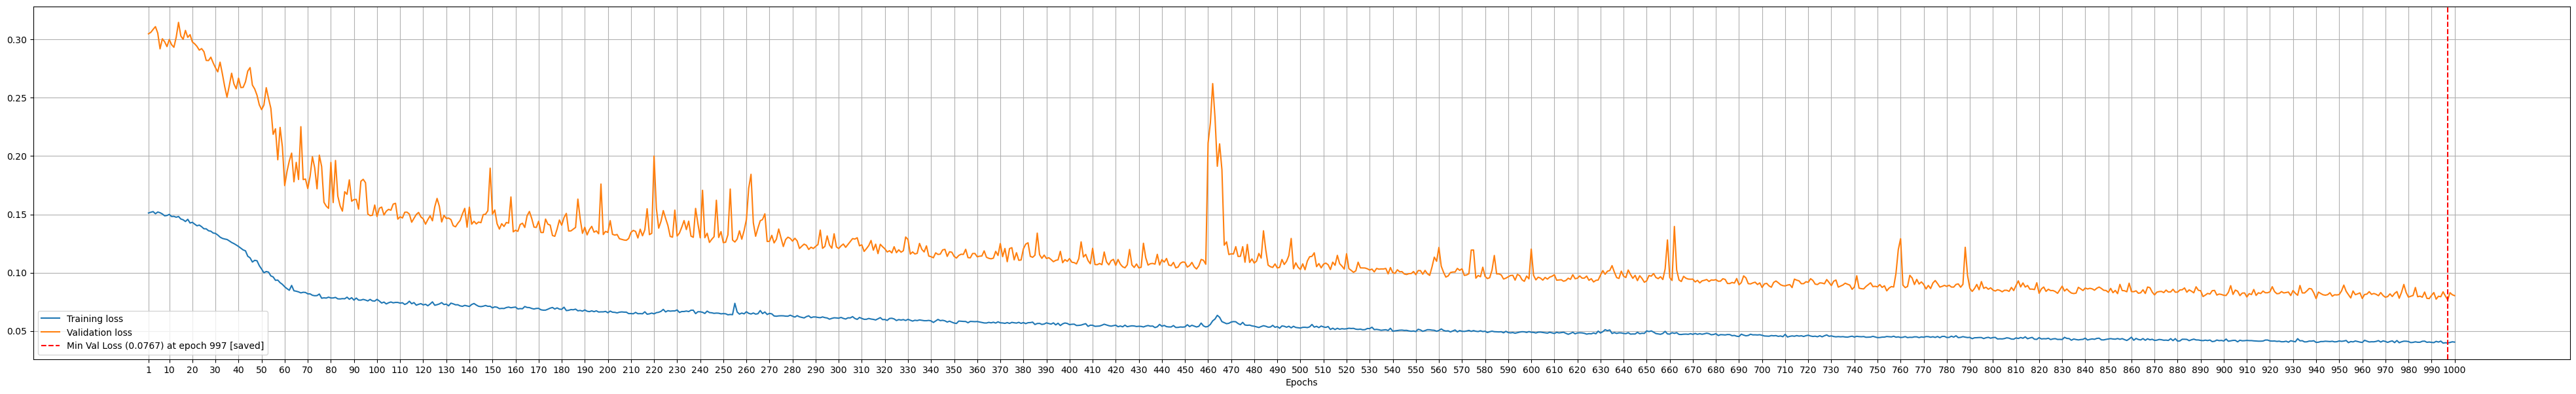

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

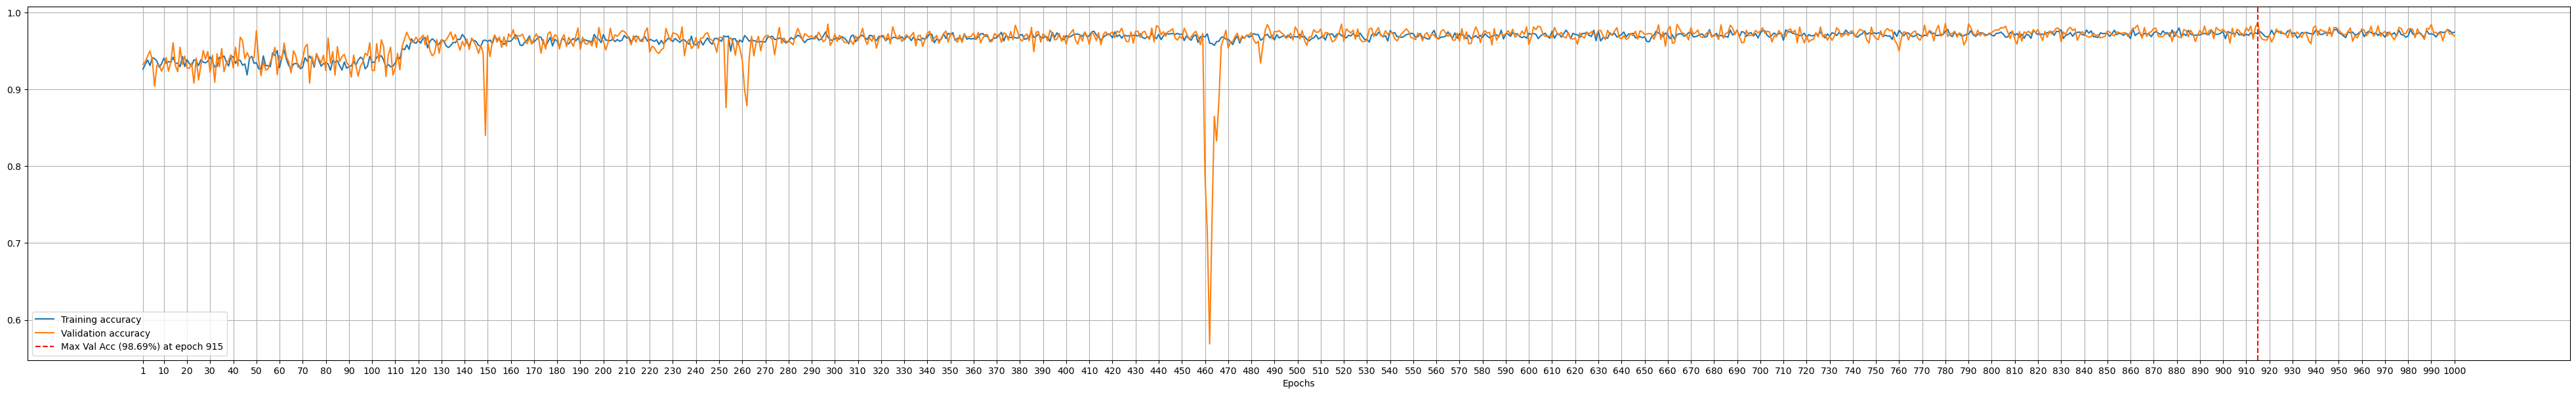

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/2nd_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


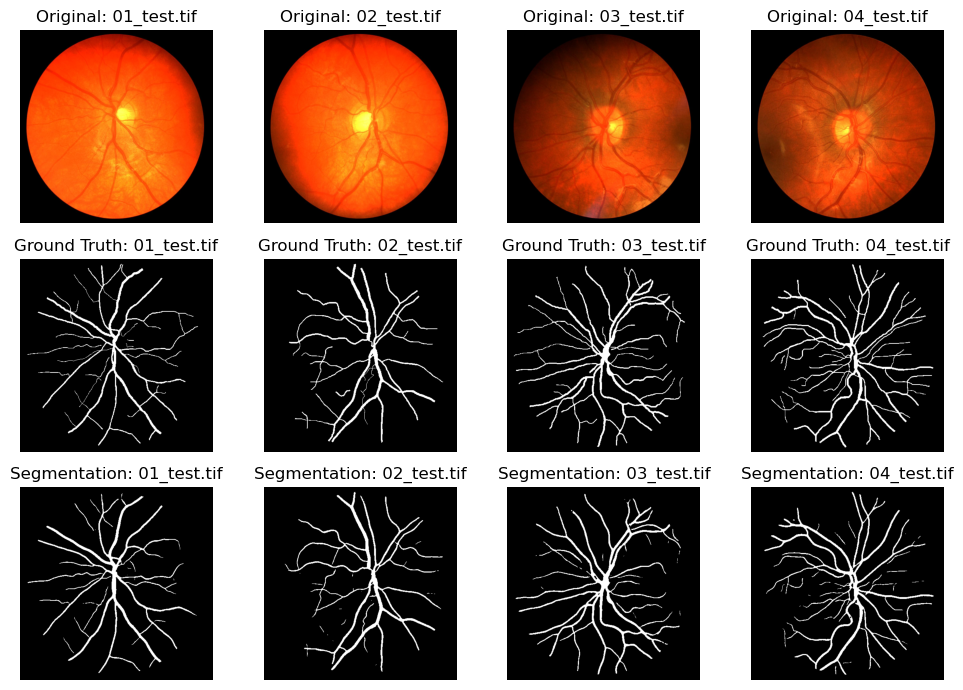

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

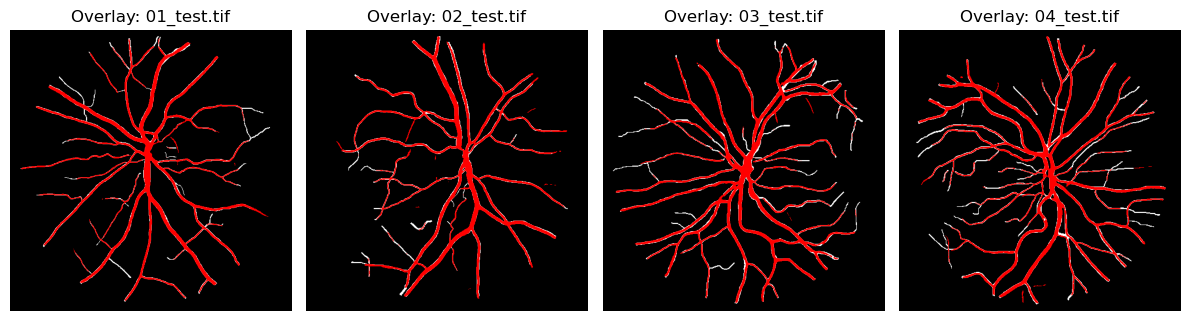

In [23]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.8175

MCC: 0.8046

ccDice score: 0.1836

Test Accuracy: 0.9751

F1 Score: 0.8172




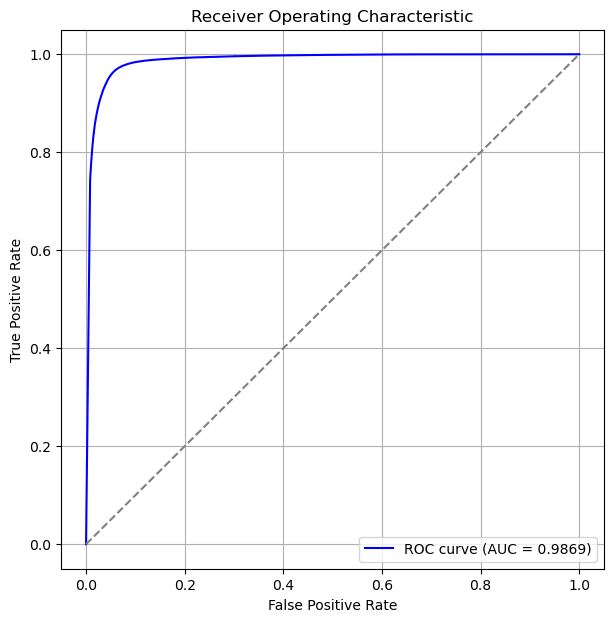

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250205_182055_ViGUNet_0.05962

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'